<a href="https://colab.research.google.com/github/rushil1904/IPL-Team-Analysis-2025/blob/main/notebooks/IPL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import time
from urllib.parse import quote
import numpy as np
import re

error_retrieval = []

def get_player_url(player_name):
    """Search for a player's URL on ESPNCricinfo and extract their profile URL"""
    search_url = f"https://www.espncricinfo.com/ci/content/player/search.html?search={quote(player_name)}"

    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.5359.125 Safari/537.36"
    }

    try:
        response = requests.get(search_url, headers=headers)
        if response.status_code == 200:
            soup = BeautifulSoup(response.text, 'html.parser')
            player_links = soup.select('.playersearch-link')

            if not player_links:
                name_parts = player_name.lower().split()
                player_links = soup.find_all('a', href=True)
                player_links = [link for link in player_links if all(part in link.text.lower() for part in name_parts)]

            if player_links:
                href = player_links[0]['href']

                if '/content/player/' in href:
                    player_id = href.split('/')[-1].replace('.html', '')
                    player_url = f"https://www.espncricinfo.com/cricketers/{player_name.lower().replace(' ', '-')}-{player_id}"
                else:
                    player_url = f"https://www.espncricinfo.com{href}" if href.startswith('/') else href

                print(f"Found player URL: {player_url}")
                return player_url
            else:
                print(f"No player link found for {player_name}")
                error_retrieval.append(player_name)
    except Exception as e:
        print(f"Error searching for {player_name}: {str(e)}")
        error_retrieval.append(player_name)
    return None

def get_career_stats(url):
    """Get player stats from their ESPNCricinfo profile page"""
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.5359.125 Safari/537.36"
    }

    try:
        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            from io import StringIO
            tables = pd.read_html(StringIO(response.text))
            if tables:
                # Return only the first table (career stats)
                return tables[0]
        else:
            print(f"Error: {response.status_code} - {response.reason}")
    except Exception as e:
        print(f"Error fetching stats from {url}: {str(e)}")
        error_retrieval.append(url)
    return None

def get_player_stats(url):
    """Get player stats from their ESPNCricinfo profile page"""
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.5359.125 Safari/537.36"
    }

    try:
        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            from io import StringIO
            tables = pd.read_html(StringIO(response.text))
            print(f"Found {len(tables)} tables on the page")

            batting_df = None
            bowling_df = None

            # Process each table
            for i, table in enumerate(tables):
                print(f"\nTable {i} columns:")
                print(table.columns.tolist())

                # Check if this is a career stats table by looking for Format column
                # and checking if it contains standard formats (T20s, FC, List A)
                if 'Format' in table.columns:
                    formats = table['Format'].astype(str).tolist()
                    if any(fmt in ['T20s', 'FC', 'List A', 'T20Is'] for fmt in formats):
                        # Check if batting or bowling table
                        if 'SR' in table.columns and 'HS' in table.columns:
                            print(f"Table {i} identified as career batting table")
                            batting_df = table
                        elif 'Wkts' in table.columns and 'Econ' in table.columns:
                            print(f"Table {i} identified as career bowling table")
                            bowling_df = table

            if batting_df is not None:
                print("\nBatting formats found:", batting_df['Format'].unique())
            if bowling_df is not None:
                print("\nBowling formats found:", bowling_df['Format'].unique())

            return batting_df, bowling_df
    except Exception as e:
        print(f"Error fetching stats from {url}: {str(e)}")
        import traceback
        print(traceback.format_exc())
        error_retrieval.append(url)
    return None, None


def clean_numeric(value):
    """Clean numeric values, handling '-' and '*'"""
    if pd.isna(value) or value == '-':
        return 0
    return float(str(value).replace('*', ''))

def clean_numeric_column(series):
    """Clean a numeric column, handling strings, '-' and '*'"""
    def clean_value(val):
        if pd.isna(val) or val == '-':
            return 0
        # Remove any non-numeric characters except decimal point
        cleaned = re.sub(r'[^0-9.]', '', str(val))
        # Handle cases where multiple numbers might be concatenated
        if cleaned.count('.') > 1:
            # Take the first valid number
            cleaned = cleaned.split('.')[0] + '.' + cleaned.split('.')[1]
        try:
            return float(cleaned)
        except:
            return 0
    return series.apply(clean_value)

def parse_bbi(bbi_str):
    """Parse BBI string to extract wickets and runs"""
    if pd.isna(bbi_str) or bbi_str == '-':
        return 0, 0
    try:
        wickets, runs = bbi_str.split('/')
        return int(wickets), int(runs)
    except:
        return 0, 0

def process_player_stats(batting_df, bowling_df, player_name):
    """Process and combine stats for a player with proper DataFrame handling"""
    print(f"\nProcessing stats for {player_name}")
    print(f"Batting table shape: {batting_df.shape if batting_df is not None else 'None'}")
    print(f"Bowling table shape: {bowling_df.shape if bowling_df is not None else 'None'}")

    combined_stats = {
        'Player': player_name,
        'Matches': 0,
        'Innings_Bat': 0,
        'Runs': 0,
        'HS': 0,
        'Avg_Bat': 0,
        'SR_Bat': 0,
        'Hundreds': 0,
        'Fifties': 0,
        'Innings_Bowl': 0,
        'Overs': 0,
        'Wickets': 0,
        'BBI': '-',
        'Best_Wickets': 0,
        'SR_Bowl': 0,
        'Econ': 0,
        'Avg_Bowl': 0,
        'Four_Wicket_Hauls': 0,
        'Five_Wicket_Hauls': 0
    }

    try:
        if batting_df is not None:
            # Enable copy-on-write
            pd.options.mode.copy_on_write = True

            # Convert 'Mat' column to numeric
            batting_df = batting_df.assign(
                Mat=pd.to_numeric(batting_df['Mat'], errors='coerce').fillna(0)
            )

            t20_batting = batting_df[batting_df['Format'].str.contains('T20', na=False)].copy()
            total_t20_matches = t20_batting['Mat'].sum() if not t20_batting.empty else 0
            include_other_formats = total_t20_matches < 5
            combined_stats['Formats_Included'] = 'T20s_Only' if not include_other_formats else 'All_Formats'
            print(f"Including {'all formats' if include_other_formats else 'only T20s'}")

            # Select relevant formats
            formats_to_include = ['T20s', 'T20Is', 'List A', 'FC'] if include_other_formats else ['T20s', 'T20Is']

            # Create explicit copies for modification
            relevant_batting = batting_df[batting_df['Format'].isin(formats_to_include)].copy()
            relevant_bowling = bowling_df[bowling_df['Format'].isin(formats_to_include)].copy() if bowling_df is not None else None

            # Process batting stats
            if not relevant_batting.empty:
                print("\nProcessing batting stats:")
                print(f"Relevant formats found: {relevant_batting['Format'].unique()}")

                # Use .loc for assignment
                relevant_batting.loc[:, 'NO'] = clean_numeric_column(relevant_batting['NO'])
                relevant_batting.loc[:, 'Inns'] = clean_numeric_column(relevant_batting['Inns'])
                relevant_batting.loc[:, 'Runs'] = clean_numeric_column(relevant_batting['Runs'])
                relevant_batting.loc[:, 'SR'] = clean_numeric_column(relevant_batting['SR'])

                no_outs = relevant_batting['NO'].sum()
                innings = relevant_batting['Inns'].sum()
                runs = relevant_batting['Runs'].sum()

                avg_bat = runs / (innings - no_outs) if (innings - no_outs) > 0 else 0
                sr_bat = relevant_batting['SR'].mean() if not relevant_batting['SR'].empty else 0

                combined_stats.update({
                    'Matches': relevant_batting['Mat'].sum(),
                    'Innings_Bat': innings,
                    'Runs': runs,
                    'HS': clean_numeric_column(relevant_batting['HS']).max(),
                    'Avg_Bat': avg_bat,
                    'SR_Bat': sr_bat,
                    'Hundreds': clean_numeric_column(relevant_batting['100s'] if '100s' in relevant_batting else pd.Series([])).sum(),
                    'Fifties': clean_numeric_column(relevant_batting['50s'] if '50s' in relevant_batting else pd.Series([])).sum()
                })
                print("Batting stats processed successfully")

        # Process bowling stats
        if relevant_bowling is not None and not relevant_bowling.empty:
            print("\nProcessing bowling stats:")
            print(f"Relevant formats found: {relevant_bowling['Format'].unique()}")

            # Use .loc for assignment
            relevant_bowling.loc[:, 'Balls'] = clean_numeric_column(relevant_bowling['Balls'] if 'Balls' in relevant_bowling else pd.Series([]))
            relevant_bowling.loc[:, 'Overs'] = clean_numeric_column(relevant_bowling['Overs'] if 'Overs' in relevant_bowling else pd.Series([]))
            relevant_bowling.loc[:, 'Runs'] = clean_numeric_column(relevant_bowling['Runs'])
            relevant_bowling.loc[:, 'Wkts'] = clean_numeric_column(relevant_bowling['Wkts'])

            total_balls = (
                relevant_bowling['Balls'].sum()
                if 'Balls' in relevant_bowling.columns
                else relevant_bowling['Overs'].sum() * 6
            )
            total_runs = relevant_bowling['Runs'].sum()
            total_wickets = relevant_bowling['Wkts'].sum()

            best_bbi = '-'
            best_wickets = 0
            if 'BBI' in relevant_bowling.columns:
                for bbi in relevant_bowling['BBI']:
                    if pd.notna(bbi) and bbi != '-':
                        wickets, _ = parse_bbi(bbi)
                        if wickets > best_wickets:
                            best_wickets = wickets
                            best_bbi = bbi

            combined_stats.update({
                'Innings_Bowl': clean_numeric_column(relevant_bowling['Inns']).sum(),
                'Overs': round(total_balls / 6, 1),
                'Wickets': total_wickets,
                'BBI': best_bbi,
                'Best_Wickets': best_wickets,
                'SR_Bowl': (total_balls / total_wickets) if total_wickets > 0 else 0,
                'Econ': ((total_runs * 6) / total_balls) if total_balls > 0 else 0,
                'Avg_Bowl': (total_runs / total_wickets) if total_wickets > 0 else 0,
                'Four_Wicket_Hauls': clean_numeric_column(relevant_bowling['4w'] if '4w' in relevant_bowling else pd.Series([])).sum(),
                'Five_Wicket_Hauls': clean_numeric_column(relevant_bowling['5w'] if '5w' in relevant_bowling else pd.Series([])).sum()
            })
            print("Bowling stats processed successfully")

    except Exception as e:
        print(f"Error processing stats for {player_name}: {str(e)}")
        import traceback
        print(traceback.format_exc())
        error_retrieval.append(player_name)

    return combined_stats


In [ ]:
def compile_player_stats():
    """Compile stats for all players into a single DataFrame"""
    teams = {
        'CSK': [
            "Ruturaj Gaikwad", "Devon Conway", "Rahul Tripathi", "MS Dhoni",
            "Shivam Dube", "Ravindra Jadeja", "Ravichandran Ashwin", "Noor Ahmed",
            "Sam Curran", "Khaleel Ahmed", "Matheesha Pathirana", "Vijay Shankar",
            "Rachin Ravindra", "Anshul Kamboj", "Deepak Hooda", "Shaik Rasheed",
            "Mukesh Choudhary", "Gurjapneet Singh", "Nathan Ellis", "Jamie Overton",
            "Kamlesh Nagarkoti", "Ramakrishna Ghosh", "Shreyas Gopal", "Vansh Bedi",
            "Andre Siddarth"
        ],
        'DC': [
            "KL Rahul", "Jake McGurk", "Abishek Porel", "Harry Brook",
            "Tristan Stubbs", "Ashutosh Sharma", "Axar Patel", "Kuldeep Yadav",
            "Mitchell Starc", "T Natarajan", "Mukesh Kumar", "Sameer Rizvi",
            "Mohit Sharma", "Karun Nair", "Faf du Plessis", "Dushmantha Chameera",
            "Vipraj Nigam", "Darshan Nalkande", "Donovan Ferreira", "Ajay Mandal",
            "Manvanth Kumar", "Tripurana Vijay", "Madhav Tiwari"
        ],
        'GT': [
            "Jos Buttler", "Shubman Gill", "B Sai Sudharshan", "Kumar Kushagra",
            "Shahrukh Khan", "Rahul Tewatia", "Rashid Khan", "Washington Sundar",
            "Gerald Coetzee", "Kagiso Rabada", "Mohammed Siraj", "Anuj Rawat",
            "Prasidh Krishna", "Mahipal Lomror", "Manav Suthar", "Nishant Sindhu",
            "Arshad Khan", "Gurnoor Brar", "Sherfane Rutherford", "Sai Kishore",
            "Ishant Sharma", "Jayant Yadav", "Glenn Phillips", "Karim Janat",
            "Kulwant Khejroliya"
        ],
        'LSG': [
            "Aiden Markram", "Ayush Badoni", "Nicholas Pooran", "Rishabh Pant",
            "David Miller", "Mitchell Marsh", "Abdul Samad", "Ravi Bishnoi",
            "Akash Deep", "Mayank Dagar", "Avesh Khan", "Mohsin Khan",
            "Manimaran Siddharth", "Shahbaz Ahamed", "Himmat Singh", "Digvesh Singh",
            "Shamar Joseph", "Aryan Juyal", "Akash Singh", "Prince Yadav",
            "Yuvraj Chaudhary", "Rajvardhan Hangargekar", "Arshin Kulkarni",
            "Matthew Breetzke"
        ],
        'KKR': [
            "Quinton de Kock", "Sunil Narine", "Venkatesh Iyer", "Rinku Singh",
            "Andre Russell", "Ramandeep Singh", "Angkrish Raghuvanshi", "Harshit Rana",
            "Anrich Nortje", "Varun Chakravarthy", "Vaibhav Arora", "MK Pandey",
            "Rahmanullah Gurbaz", "Rovman Powell", "Mayank Markande", "Spencer Johnson",
            "Luvnith Sisodia", "Ajinkya Rahane", "Anukul Roy", "Moeen Ali",
            "Umran Malik"
        ],
        'MI': [
            "Rohit Sharma", "Ryan Rickelton", "Tilak Varma", "Suryakumar Yadav",
            "Naman Dhir", "Hardik Pandya", "Deepak Chahar", "AM Ghazanfar",
            "Karn Sharma", "Jasprit Bumrah", "Trent Boult", "Will Jacks",
            "Mitchell Santner", "Robin Minz", "Ashwini Kumar", "Reece Topley",
            "Shrijith Krishnan", "Raj Bawa", "Satyanarayana Raju", "Bevon Jacobs",
            "Arjun Tendulkar", "Lizaad Williams", "Vignesh Puthur"
        ],
        'PBKS': [
            'Marcus Stoinis', 'Prabhsimran Singh', 'Shreyas Iyer', 'Glenn Maxwell',
            'Nehal Wadhera', 'Shashank Singh', 'Marco Jansen', 'Harpreet Brar',
            'Arshdeep Singh', 'Yuzvendra Chahal', 'Lockie Ferguson', 'Priyansh Arya',
            'Josh Inglis', 'VijayKumar Vyshak', 'Azmatullah Omarzai', 'Vishnu Vinod',
            'Harnoor Singh', 'Kuldeep Sen', 'Yash Thakur', 'Aaron Hardie',
            'Musheer Khan', 'Suryansh Shedge', 'Xavier Bartlett', 'Pyla Avinash',
            'Praveen Dubey'
        ],
        'RR': [
            'Sanju Samson', 'Yashasvi Jaiswal', 'Nitish Rana', 'Dhruv Jurel',
            'Riyan Parag', 'Shimron Hetmyer', 'Wanindu Hasaranga', 'Akash Madhwal',
            'Maheesh Theekshana', 'Sandeep Sharma', 'Jofra Archer', 'Shubham Dubey',
            'Tushar Deshpande', 'Kartikeya Singh', 'Yudhvir Singh', 'Fazalhaq Farooqi',
            'Vaibhav Suryavanshi', 'Kwena Maphaka', 'Kunal Rathore', 'Ashok Sharma'
        ],
        'RCB': [
            'Virat Kohli', 'Phil Salt', 'Rajat Patidar', 'Liam Livingstone',
            'Jitesh Sharma', 'Krunal Pandya', 'Tim David', 'Suyash Sharma',
            'Bhuvneshwar Kumar', 'Yash Dayal', 'Josh Hazlewood', 'Rasikh Salam',
            'Devdutt Padikkal', 'Swapnil Singh', 'Nuwan Thushara', 'Manoj Bhandage',
            'Jacob Bethell', 'Romario Shepherd', 'Swastik Chikara', 'Lungi Ngidi',
            'Abhinandan Singh', 'Mohit Rathee'
        ],
        'SRH': [
            'Travis Head', 'Abhishek Sharma', 'Nitish Kumar Reddy', 'Ishan Kishan',
            'Heinrich Klaasen', 'Abhinav Manohar', 'Pat Cummins', 'Harshal Patel',
            'Rahul Chahar', 'Mohammed Shami', 'Adam Zampa', 'Atharva Taide',
            'Simarjeet Singh', 'Zeeshan Ansari', 'Jaydev Unadkat', 'Brydon Carse',
            'Kamindu Mendis', 'Aniket Verma', 'Eshan Malinga', 'Sachin Baby'
        ]
    }

    team_dataframes = {}

    # Process each team separately
    for team, players in teams.items():
        print(f"\nProcessing team: {team}")
        t20_stats = []

        for player_name in players:
            print(f"Processing {player_name}...")

            url = get_player_url(player_name)
            if url:
                batting_table, bowling_table = get_player_stats(url)
                if batting_table is not None or bowling_table is not None:
                    stats = process_player_stats(batting_table, bowling_table, player_name)
                    t20_stats.append(stats)
                    print(f"Successfully processed stats for {player_name}")
                else:
                    print(f"Could not retrieve stats for {player_name}")
            else:
                print(f"Could not find URL for {player_name}")

            time.sleep(2)

        if t20_stats:
                # Create DataFrame for this team
                team_df = pd.DataFrame(t20_stats)

                # Round numeric columns
                numeric_cols = team_df.select_dtypes(include=[np.number]).columns
                team_df[numeric_cols] = team_df[numeric_cols].round(2)

                # Store DataFrame in dictionary
                team_dataframes[team] = team_df

                # # Save to CSV
                # csv_filename = f'{team.lower()}_t20_stats.csv'
                # team_df.to_csv(csv_filename, index=False)
                # print(f"\nStats for {team} saved to {csv_filename}")
        else:
            print(f"No stats could be retrieved for {team}")
            team_dataframes[team] = pd.DataFrame()  # Empty DataFrame if no stats retrieved

    return team_dataframes

if __name__ == "__main__":
    # Get all team DataFrames
    team_t20_dfs = compile_player_stats()

Streaming output truncated to the last 5000 lines.
    raise ValueError("No tables found")
ValueError: No tables found

Could not retrieve stats for Digvesh Singh
Processing Shamar Joseph...
Found player URL: https://www.espncricinfo.com/cricketers/shamar-joseph-1356971
Found 5 tables on the page

Table 0 columns:
['Format', 'Mat', 'Inns', 'Balls', 'Runs', 'Wkts', 'BBI', 'BBM', 'Ave', 'Econ', 'SR', '4w', '5w', '10w']
Table 0 identified as career bowling table

Table 1 columns:
['Format', 'Mat', 'Inns', 'NO', 'Runs', 'HS', 'Ave', 'BF', 'SR', '100s', '50s', '4s', '6s', 'Ct', 'St']
Table 1 identified as career batting table

Table 2 columns:
['Tournament', 'Teams', 'Mat', 'Inns', 'Balls', 'Runs', 'Wkts', 'BBI', 'BBM', 'Ave', 'Econ', 'SR', '4w', '5w', '10w']

Table 3 columns:
['Tournament', 'Teams', 'Mat', 'Inns', 'NO', 'Runs', 'HS', 'Ave', 'BF', 'SR', '100s', '50s', '4s', '6s', 'Ct', 'St']

Table 4 columns:
['Match', 'Bat', 'Bowl', 'Date', 'Ground', 'Format']

Batting formats found: ['Tes

In [ ]:
error_retrieval

['https://www.espncricinfo.com/cricketers/vijay-shankar-33930',
 'T Natarajan',
 'https://www.espncricinfo.com/cricketers/mukesh-kumar-279677',
 'https://www.espncricinfo.com/cricketers/madhav-tiwari-1460385',
 'B Sai Sudharshan',
 'https://www.espncricinfo.com/cricketers/shahrukh-khan-1141898',
 'https://www.espncricinfo.com/cricketers/rashid-khan-25923',
 'Shahbaz Ahamed',
 'https://www.espncricinfo.com/cricketers/digvesh-singh-1350775',
 'Ashwini Kumar',
 'https://www.espncricinfo.com/cricketers/vignesh-puthur-1460388',
 'https://www.espncricinfo.com/cricketers/sandeep-sharma-34508',
 'https://www.espncricinfo.com/cricketers/kartikeya-singh-1449049',
 'https://www.espncricinfo.com/cricketers/ashok-sharma-1299879',
 'https://www.espncricinfo.com/cricketers/aniket-verma-1409976']

In [ ]:
import pandas as pd

def add_players_to_dataframe(team_dataframes, new_players):
    """Adds new players and their stats to the existing team DataFrames.

    Args:
        team_dataframes: A dictionary of team DataFrames.
        new_players: A dictionary where keys are team names and values are lists of new player dictionaries.
                     Each player dictionary should contain player stats as key-value pairs (matching DataFrame columns).

    Returns:
        An updated dictionary of team DataFrames with the new players added.
    """
    for team, players in new_players.items():
        if team in team_dataframes:
            team_df = team_dataframes[team]
            new_player_df = pd.DataFrame(players)

            #Handle potential missing columns in new_player_df
            for col in team_df.columns:
              if col not in new_player_df.columns:
                new_player_df[col] = 0  # Fill with zeros or other appropriate value

            team_dataframes[team] = pd.concat([team_df, new_player_df], ignore_index=True)
            print(f"Added {len(players)} new player(s) to {team}'s DataFrame")
        else:
            print(f"Team '{team}' not found in the DataFrame dictionary.")

    return team_dataframes


# Example usage (replace with your actual data):
new_player_data = {
    'CSK': [
        {'Player': 'Vijay Shankar', 'Matches': 153, 'Innings_Bat': 118.0, 'Runs': 2434.0, 'HS': 69.0, 'Avg_Bat': 26.75, 'SR_Bat': 130.51, 'Hundreds': 0.0, 'Fifties': 10.0, 'Innings_Bowl': 71.0, 'Overs': 166.3,  'Wickets': 41.0, 'BBI': 3/12, 'Best_Wickets': 3, 'SR_Bowl': 24.34, 'Econ': 8.30, 'Avg_Bowl': 33.66, 'Four_Wicket_Hauls': 0, 'Five_Wicket_Hauls': 0.0, 'Formats_Included': 'T20s_Only'},
    ],
    'DC': [
        {'Player': 'T Natarajan', 'Matches': 99, 'Innings_Bat': 6.0, 'Runs': 8.0, 'HS': 3.0, 'Avg_Bat': 8.0, 'SR_Bat': 53.33, 'Hundreds': 0.0, 'Fifties': 0.0, 'Innings_Bowl': 99.0, 'Overs': 373.0,  'Wickets': 111.0, 'BBI': 4/19, 'Best_Wickets': 4, 'SR_Bowl': 19.26, 'Econ': 8.41, 'Avg_Bowl': 27.01, 'Four_Wicket_Hauls': 1.0, 'Five_Wicket_Hauls': 0.0, 'Formats_Included': 'T20s_Only'},
        {'Player': 'Mukesh Kumar', 'Matches': 82, 'Innings_Bat': 20.0, 'Runs': 25.0, 'HS': 6.0, 'Avg_Bat': 6.25, 'SR_Bat': 67.57, 'Hundreds': 0.0, 'Fifties': 0.0, 'Innings_Bowl': 82.0, 'Overs': 273.6,  'Wickets': 91.0, 'BBI': 4/22, 'Best_Wickets': 4, 'SR_Bowl': 18.04, 'Econ': 8.90, 'Avg_Bowl': 26.76, 'Four_Wicket_Hauls': 2.0, 'Five_Wicket_Hauls': 0.0, 'Formats_Included': 'T20s_Only'}
    ],
    'GT': [
        {'Player': 'B Sai Sudharshan', 'Matches': 46, 'Innings_Bat': 44.0, 'Runs': 1512.0, 'HS': 103.0, 'Avg_Bat': 39.79, 'SR_Bat': 130.46, 'Hundreds': 1.0, 'Fifties': 8.0, 'Innings_Bowl': 0, 'Overs': 0,  'Wickets': 0, 'BBI': 'N/A', 'Best_Wickets': 0, 'SR_Bowl': 0.00, 'Econ': 0.00, 'Avg_Bowl': 0.00, 'Four_Wicket_Hauls': 0.0, 'Five_Wicket_Hauls': 0.0, 'Formats_Included': 'T20s_Only'},
        {'Player': 'M Shahrukh Khan', 'Matches': 93, 'Innings_Bat': 79.0, 'Runs': 1125.0, 'HS': 58.0, 'Avg_Bat': 19.4, 'SR_Bat': 138.38, 'Hundreds': 0.0, 'Fifties': 1.0, 'Innings_Bowl': 12.0, 'Overs': 24.3,  'Wickets': 4.0, 'BBI': 1/9, 'Best_Wickets': 1, 'SR_Bowl': 36.5, 'Econ': 8.71, 'Avg_Bowl': 53.00, 'Four_Wicket_Hauls': 0.0, 'Five_Wicket_Hauls': 0.0, 'Formats_Included': 'T20s_Only'},
        {'Player': 'Rashid Khan', 'Matches': 541, 'Innings_Bat': 326.0, 'Runs': 2997.0, 'HS': 79.0, 'Avg_Bat': 13.88, 'SR_Bat': 144.00, 'Hundreds': 0.0, 'Fifties': 5.0, 'Innings_Bowl': 538.0, 'Overs': 2069.0,  'Wickets': 765.0, 'BBI': 6/17, 'Best_Wickets': 6, 'SR_Bowl': 16.23, 'Econ': 6.43, 'Avg_Bowl': 17.36, 'Four_Wicket_Hauls': 22.0, 'Five_Wicket_Hauls': 6.0, 'Formats_Included': 'T20s_Only'}
    ],
    'LSG': [
        {'Player': 'Shahbaz Ahmed', 'Matches': 102, 'Innings_Bat': 66.0, 'Runs': 1169.0, 'HS': 100.0, 'Avg_Bat': 25.41, 'SR_Bat': 133.14, 'Hundreds': 1.0, 'Fifties': 3.0, 'Innings_Bowl': 89.0, 'Overs': 242.17,  'Wickets': 66.0, 'BBI': 3/7, 'Best_Wickets': 3, 'SR_Bowl': 22.02, 'Econ': 7.75, 'Avg_Bowl': 28.41, 'Four_Wicket_Hauls': 0.0, 'Five_Wicket_Hauls': 0.0, 'Formats_Included': 'T20s_Only'}
    ],
    'MI': [
        {'Player': 'Ashwani Kumar', 'Matches': 6, 'Innings_Bat': 3.0, 'Runs': 26.0, 'HS': 22.0, 'Avg_Bat': 'N/A', 'SR_Bat': 66.67, 'Hundreds': 0.0, 'Fifties': 0.0, 'Innings_Bowl': 8.0, 'Overs': 59.3,  'Wickets': 4.0, 'BBI': 1/26, 'Best_Wickets': 1, 'SR_Bowl': 89.00, 'Econ': 4.95, 'Avg_Bowl': 73.5, 'Four_Wicket_Hauls': 0.0, 'Five_Wicket_Hauls': 0.0, 'Formats_Included': 'All_Formats'}
    ],
    'RR': [
        {'Player': 'Sandeep Sharma', 'Matches': 193, 'Innings_Bat': 43.0, 'Runs': 107.0, 'HS': 13.0, 'Avg_Bat': 10.7, 'SR_Bat': 85.60, 'Hundreds': 0.0, 'Fifties': 0.0, 'Innings_Bowl': 191.0, 'Overs': 704.83,  'Wickets': 214.0, 'BBI': 5/18, 'Best_Wickets': 5, 'SR_Bowl': 30.8, 'Econ': 9.0, 'Avg_Bowl': 25.11, 'Four_Wicket_Hauls': 4.0, 'Five_Wicket_Hauls': 1.0, 'Formats_Included': 'T20s_Only'},
        {'Player': 'Kartikeya Singh', 'Matches': 34, 'Innings_Bat': 7.0, 'Runs': 22.0, 'HS': 6.0, 'Avg_Bat': 5.5, 'SR_Bat': 95.65, 'Hundreds': 0.0, 'Fifties': 5.0, 'Innings_Bowl': 34.0, 'Overs': 117.0,  'Wickets': 38.0, 'BBI': 3/10, 'Best_Wickets': 3, 'SR_Bowl': 18.47, 'Econ': 7.04, 'Avg_Bowl': 21.68, 'Four_Wicket_Hauls': 0.0, 'Five_Wicket_Hauls': 0.0, 'Formats_Included': 'T20s_Only'}
    ]
}


team_t20_dfs = add_players_to_dataframe(team_t20_dfs, new_player_data)

csk_t20_df = team_t20_dfs['CSK']
dc_t20_df = team_t20_dfs['DC']
gt_t20_df = team_t20_dfs['GT']
lsg_t20_df = team_t20_dfs['LSG']
kkr_t20_df = team_t20_dfs['KKR']
mi_t20_df = team_t20_dfs['MI']
pbks_t20_df = team_t20_dfs['PBKS']
rr_t20_df = team_t20_dfs['RR']
rcb_t20_df = team_t20_dfs['RCB']
srh_t20_df = team_t20_dfs['SRH']

Added 1 new player(s) to CSK's DataFrame
Added 2 new player(s) to DC's DataFrame
Added 3 new player(s) to GT's DataFrame
Added 1 new player(s) to LSG's DataFrame
Added 1 new player(s) to MI's DataFrame
Added 2 new player(s) to RR's DataFrame


In [ ]:
csk_t20_df.to_csv('csk_t20_df.csv', index=False)
dc_t20_df.to_csv('dc_t20_df.csv', index=False)
gt_t20_df.to_csv('gt_t20_df.csv', index=False)
lsg_t20_df.to_csv('lsg_t20_df.csv', index=False)
kkr_t20_df.to_csv('kkr_t20_df.csv', index=False)
mi_t20_df.to_csv('mi_t20_df.csv', index=False)
pbks_t20_df.to_csv('pbks_t20_df.csv', index=False)
rr_t20_df.to_csv('rr_t20_df.csv', index=False)
rcb_t20_df.to_csv('rcb_t20_df.csv', index=False)
srh_t20_df.to_csv('srh_t20_df.csv', index=False)

In [ ]:
from google.colab import drive
drive.mount('drive')

teams = ['csk', 'dc', 'gt', 'lsg', 'kkr', 'mi', 'pbks', 'rr', 'rcb', 'srh']

# Create the directory if it doesn't exist
!mkdir -p "drive/My Drive/IPL Auction"

# Copy each team's CSV file to Google Drive
for team in teams:
    filename = f"{team}_t20_df.csv"
    !cp {filename} "drive/My Drive/IPL Auction/"
    print(f"Copied {filename} to Drive/My Drive/IPL Auction/")

print("\nAll files have been copied to Google Drive successfully!")

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).
Copied csk_t20_df.csv to Drive/My Drive/IPL Auction/
Copied dc_t20_df.csv to Drive/My Drive/IPL Auction/
Copied gt_t20_df.csv to Drive/My Drive/IPL Auction/
Copied lsg_t20_df.csv to Drive/My Drive/IPL Auction/
Copied kkr_t20_df.csv to Drive/My Drive/IPL Auction/
Copied mi_t20_df.csv to Drive/My Drive/IPL Auction/
Copied pbks_t20_df.csv to Drive/My Drive/IPL Auction/
Copied rr_t20_df.csv to Drive/My Drive/IPL Auction/
Copied rcb_t20_df.csv to Drive/My Drive/IPL Auction/
Copied srh_t20_df.csv to Drive/My Drive/IPL Auction/

All files have been copied to Google Drive successfully!


In [ ]:
# Read the CSV file into a pandas DataFrame
csk_data = '/content/drive/MyDrive/IPL Auction/csk_t20_df.csv'
csk_t20_df = pd.read_csv(csk_data)

dc_data = '/content/drive/MyDrive/IPL Auction/dc_t20_df.csv'
dc_t20_df = pd.read_csv(dc_data)

gt_data = '/content/drive/MyDrive/IPL Auction/gt_t20_df.csv'
gt_t20_df = pd.read_csv(gt_data)

lsg_data = '/content/drive/MyDrive/IPL Auction/lsg_t20_df.csv'
lsg_t20_df = pd.read_csv(lsg_data)

kkr_data = '/content/drive/MyDrive/IPL Auction/kkr_t20_df.csv'
kkr_t20_df = pd.read_csv(kkr_data)

mi_data = '/content/drive/MyDrive/IPL Auction/mi_t20_df.csv'
mi_t20_df = pd.read_csv(mi_data)

pbks_data = '/content/drive/MyDrive/IPL Auction/pbks_t20_df.csv'
pbks_t20_df = pd.read_csv(pbks_data)

rr_data = '/content/drive/MyDrive/IPL Auction/rr_t20_df.csv'
rr_t20_df = pd.read_csv(rr_data)

rcb_data = '/content/drive/MyDrive/IPL Auction/rcb_t20_df.csv'
rcb_t20_df = pd.read_csv(rcb_data)

srh_data = '/content/drive/MyDrive/IPL Auction/srh_t20_df.csv'
srh_t20_df = pd.read_csv(srh_data)

print(dc_t20_df.head()) # Display the first 5 rows

           Player  Matches  Innings_Bat    Runs     HS  Avg_Bat  SR_Bat  \
0        KL Rahul      298        281.0  9851.0  132.0    40.88  137.49   
1     Jake McGurk       67         65.0  1282.0   84.0    20.68  147.72   
2   Abishek Porel       33         31.0   829.0   81.0    31.88  151.83   
3     Harry Brook      183        164.0  4065.0  105.0    33.05  148.06   
4  Tristan Stubbs      144        128.0  3008.0   80.0    31.01  141.81   

   Hundreds  Fifties  Innings_Bowl  Overs  Wickets   BBI  Best_Wickets  \
0       8.0     87.0           0.0    0.0      0.0     -             0   
1       0.0      9.0           1.0    1.0      0.0     -             0   
2       0.0      6.0           0.0    0.0      0.0     -             0   
3       3.0     16.0           2.0    2.0      1.0  1/13             1   
4       0.0     13.0          23.0   35.5     11.0   2/6             2   

   SR_Bowl  Econ  Avg_Bowl  Four_Wicket_Hauls  Five_Wicket_Hauls  \
0     0.00   0.0       0.0          

# **Chennai Super Kings**

In [ ]:
csk_t20_df

,Player,Matches,Innings_Bat,Runs,HS,Avg_Bat,SR_Bat,Hundreds,Fifties,Innings_Bowl,Overs,Wickets,BBI,Best_Wickets,SR_Bowl,Econ,Avg_Bowl,Four_Wicket_Hauls,Five_Wicket_Hauls,Formats_Included
0,Ruturaj Gaikwad,166,157.0,5408.0,123.0,39.47,141.55,7.0,36.0,0.0,0.0,0.0,-,0,0.00,0.00,0.00,0.0,0.0,T20s_Only
1,Devon Conway,237,226.0,7436.0,105.0,41.31,128.40,2.0,58.0,8.0,17.2,3.0,1/10,1,34.33,8.21,47.00,0.0,0.0,T20s_Only
2,Rahul Tripathi,165,161.0,3649.0,93.0,25.70,139.81,0.0,19.0,18.0,38.0,12.0,5/27,5,19.00,7.50,23.75,0.0,1.0,T20s_Only
3,MS Dhoni,489,427.0,9049.0,84.0,38.02,130.88,0.0,30.0,1.0,2.0,0.0,-,0,0.00,12.50,0.00,0.0,0.0,T20s_Only
4,Shivam Dube,181,155.0,3290.0,95.0,29.91,138.06,0.0,16.0,102.0,217.7,60.0,3/30,3,21.77,8.98,32.57,0.0,0.0,T20s_Only
5,Ravindra Jadeja,406,279.0,4199.0,62.0,25.30,128.80,0.0,3.0,371.0,1138.5,279.0,5/16,5,24.48,7.50,30.61,3.0,1.0,T20s_Only
6,Ravichandran Ashwin,389,154.0,1384.0,50.0,15.73,117.44,0.0,1.0,385.0,1411.0,382.0,4/8,4,22.16,7.04,26.00,6.0,0.0,T20s_Only
7,Sam Curran,313,237.0,4040.0,102.0,21.38,129.86,1.0,22.0,302.0,957.2,301.0,5/10,5,19.08,8.75,27.84,4.0,5.0,T20s_Only
8,Khaleel Ahmed,132,15.0,11.0,3.0,1.57,41.66,0.0,0.0,132.0,490.3,160.0,5/18,5,18.39,8.39,25.72,1.0,1.0,T20s_Only
9,Matheesha Pathirana,88,20.0,48.0,8.0,4.36,56.51,0.0,0.0,86.0,284.3,135.0,4/24,4,12.64,7.94,16.73,7.0,0.0,T20s_Only


In [ ]:
#Top 5 players with the best strike rate

# Sort the dataframe by SR_Bat in descending order
csk_t20_df_sorted = csk_t20_df.sort_values(by='SR_Bat', ascending=False)

# Get the top 5 players
top_5_players = csk_t20_df_sorted.head(5)

# Display the top 5 players
print(top_5_players[['Player', 'SR_Bat']])


               Player  SR_Bat
19  Ramakrishna Ghosh  150.00
17      Jamie Overton  147.74
12       Deepak Hooda  142.88
0     Ruturaj Gaikwad  141.55
2      Rahul Tripathi  139.81


# **Royal Challengers Bangalore**

In [ ]:
#Top 5 players with the best strike rate

# Sort the dataframe by SR_Bat in descending order
rcb_t20_df_sorted = rcb_t20_df.sort_values(by='SR_Bat', ascending=False)

# Get the top 5 players
top_5_players = rcb_t20_df_sorted.head(5)

# Display the top 5 players
print(top_5_players[['Player', 'SR_Bat']])


           Player  SR_Bat
6       Tim David  160.50
1       Phil Salt  160.48
16  Jacob Bethell  155.22
2   Rajat Patidar  154.88
4   Jitesh Sharma  148.11


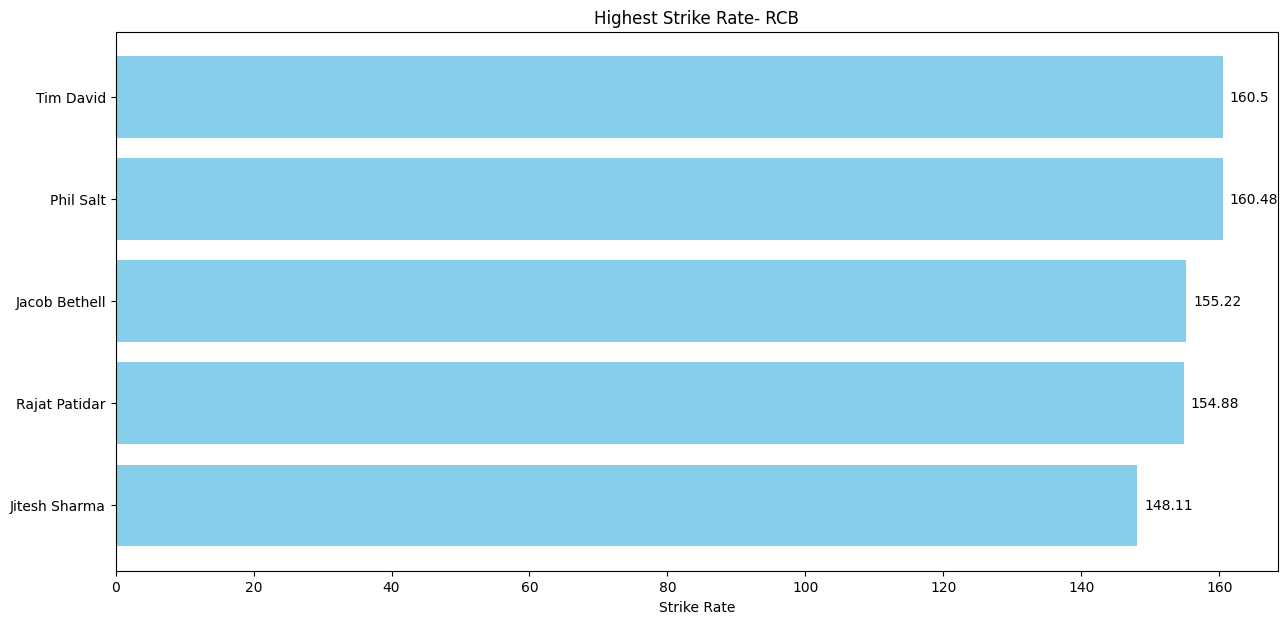

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'rcb_t20_df' is already defined and contains the RCB player data
# and has columns 'Player' and 'SR_Bat'

# Sort the dataframe by SR_Bat in descending order
rcb_t20_df_sorted = rcb_t20_df.sort_values(by='SR_Bat', ascending=False)

# Get the top 5 players
top_5_players = rcb_t20_df_sorted.head(5)

# Extract player names and SR_Bat values
players = top_5_players['Player']
sr_bat = top_5_players['SR_Bat']

# Create the horizontal bar plot
plt.figure(figsize=(15,7))  # Adjust figure size for better readability
plt.barh(players, sr_bat, color='skyblue')
plt.xlabel("Strike Rate")
plt.title("Highest Strike Rate- RCB")
plt.gca().invert_yaxis()  # Invert y-axis to show highest SR at the top


# Add exact SR_Bat values next to each bar
for i, v in enumerate(sr_bat):
    plt.text(v + 1, i, str(v), color='black', va='center')

plt.show()

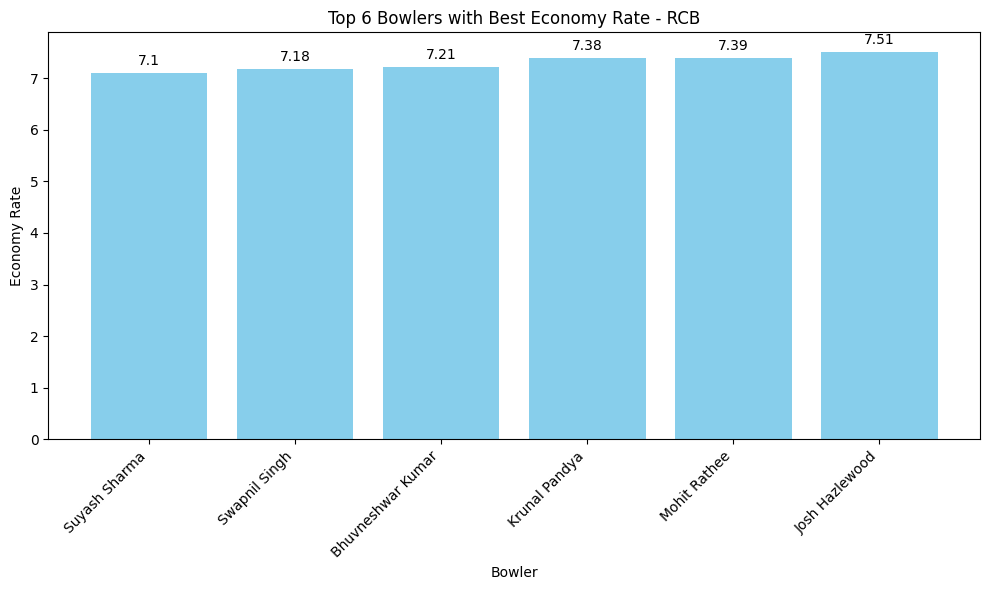

In [ ]:
import matplotlib.pyplot as plt

# Filter for bowlers with minimum 4 economy rate and minimum 12 overs bowled
rcb_bowlers = rcb_t20_df[(rcb_t20_df['Econ'] >= 4) & (rcb_t20_df['Innings_Bowl'] >= 5)]

# Sort by economy rate in ascending order
rcb_bowlers_sorted = rcb_bowlers.sort_values(by='Econ')

# Get the top 6 bowlers
top_6_bowlers = rcb_bowlers_sorted.head(6)

# Extract player names and economy rates
players = top_6_bowlers['Player']
economy_rates = top_6_bowlers['Econ']

# Create the vertical bar plot
plt.figure(figsize=(10, 6))
plt.bar(players, economy_rates, color='skyblue')
plt.xlabel("Bowler")
plt.ylabel("Economy Rate")
plt.title("Top 6 Bowlers with Best Economy Rate - RCB")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping

# Add exact economy rate values above each bar
for i, v in enumerate(economy_rates):
    plt.text(i, v + 0.1, str(v), ha='center', va='bottom')

plt.show()

In [ ]:
# Sort RCB bowlers by economy and average, with minimum innings bowled
min_innings = 20
rcb_bowlers = rcb_t20_df[rcb_t20_df['Innings_Bowl'] >= min_innings]
sorted_bowlers = rcb_bowlers.sort_values(by=['Econ', 'Avg_Bowl'])
print(sorted_bowlers[['Player', 'Econ', 'Avg_Bowl', 'Innings_Bowl']])

               Player  Econ  Avg_Bowl  Innings_Bowl
7       Suyash Sharma  7.10     20.37          24.0
13      Swapnil Singh  7.18     24.67          81.0
8   Bhuvneshwar Kumar  7.21     24.58         376.0
5       Krunal Pandya  7.38     31.73         210.0
10     Josh Hazlewood  7.51     22.25         159.0
14     Nuwan Thushara  8.03     18.16         122.0
11       Rasikh Salam  8.46     21.79          32.0
9          Yash Dayal  8.47     29.45          56.0
3    Liam Livingstone  8.50     25.56         195.0
19        Lungi Ngidi  8.54     20.57         174.0
0         Virat Kohli  8.54     72.58          58.0
15     Manoj Bhandage  8.75     24.06          20.0
6           Tim David  8.99     58.80          68.0
17   Romario Shepherd  9.31     25.69         182.0


In [ ]:

mohit_rathee_stats = rcb_t20_df[rcb_t20_df['Player'] == 'Mohit Rathee']

# Check if Mohit Rathee's stats were found
if not mohit_rathee_stats.empty:
    # Display Mohit Rathee's stats
    print(mohit_rathee_stats)
else:
    print("Stats for Mohit Rathee not found in the DataFrame.")

          Player  Matches  Innings_Bat  Runs    HS  Avg_Bat  SR_Bat  Hundreds  \
20  Mohit Rathee       11            8    67  33.0     13.4  142.55       0.0   

    Fifties  Innings_Bowl  Overs  Wickets   BBI  Best_Wickets  SR_Bowl  Econ  \
20      0.0          11.0   36.7      8.0  2/16             2     27.5  7.39   

    Avg_Bowl  Four_Wicket_Hauls  Five_Wicket_Hauls Formats_Included  
20     33.88                0.0                0.0        T20s_Only  


In [ ]:
# Sort the dataframe by Wickets in descending order
rcb_t20_df_sorted = rcb_t20_df.sort_values(by='Wickets', ascending=False)

# Get the top 5 players
top_5_wicket_takers = rcb_t20_df_sorted.head(5)

# Display the top 5 wicket-takers
print(top_5_wicket_takers[['Player', 'Wickets']])

               Player  Wickets
8   Bhuvneshwar Kumar    395.0
19        Lungi Ngidi    240.0
10     Josh Hazlewood    203.0
17   Romario Shepherd    203.0
14     Nuwan Thushara    173.0


In [ ]:
rcb_t20_df

,Player,Matches,Innings_Bat,Runs,HS,Avg_Bat,SR_Bat,Hundreds,Fifties,Innings_Bowl,Overs,Wickets,BBI,Best_Wickets,SR_Bowl,Econ,Avg_Bowl,Four_Wicket_Hauls,Five_Wicket_Hauls,Formats_Included
0,Virat Kohli,524,499,17074,122.0,43.01,135.62,10.0,135.0,58.0,102.0,12.0,2/25,2,51.00,8.54,72.58,0.0,0.0,T20s_Only
1,Phil Salt,306,294,7623,119.0,28.34,160.48,6.0,45.0,0.0,0.0,0.0,-,0,0.00,0.00,0.00,0.0,0.0,T20s_Only
2,Rajat Patidar,70,67,2252,112.0,36.32,154.88,1.0,22.0,0.0,0.0,0.0,-,0,0.00,0.00,0.00,0.0,0.0,T20s_Only
3,Liam Livingstone,346,310,7530,103.0,27.89,147.78,3.0,37.0,195.0,475.3,158.0,4/17,4,18.05,8.50,25.56,2.0,0.0,T20s_Only
4,Jitesh Sharma,133,121,2676,106.0,25.73,148.11,1.0,10.0,1.0,1.0,0.0,-,0,0.00,5.00,0.00,0.0,0.0,T20s_Only
5,Krunal Pandya,222,178,2932,86.0,24.43,130.99,0.0,8.0,210.0,675.0,157.0,4/36,4,25.80,7.38,31.73,3.0,0.0,T20s_Only
6,Tim David,308,280,6073,92.0,30.21,160.50,0.0,21.0,68.0,130.8,20.0,1/18,1,39.25,8.99,58.80,0.0,0.0,T20s_Only
7,Suyash Sharma,24,0,0,0.0,0.00,0.00,0.0,0.0,24.0,86.0,30.0,5/13,5,17.20,7.10,20.37,1.0,1.0,T20s_Only
8,Bhuvneshwar Kumar,378,121,547,27.0,10.13,82.51,0.0,0.0,376.0,1346.8,395.0,5/4,5,20.46,7.21,24.58,8.0,7.0,T20s_Only
9,Yash Dayal,56,6,10,4.0,5.00,71.42,0.0,0.0,56.0,184.3,53.0,3/20,3,20.87,8.47,29.45,0.0,0.0,T20s_Only


# **Delhi Capitals**

In [ ]:
dc_t20_df

,Player,Matches,Innings_Bat,Runs,HS,Avg_Bat,SR_Bat,Hundreds,Fifties,Innings_Bowl,Overs,Wickets,BBI,Best_Wickets,SR_Bowl,Econ,Avg_Bowl,Four_Wicket_Hauls,Five_Wicket_Hauls,Formats_Included
0,KL Rahul,298,281.0,9851.0,132.0,40.88,137.49,8.0,87.0,0.0,0.0,0.0,-,0,0.00,0.00,0.00,0.0,0.0,T20s_Only
1,Jake McGurk,67,65.0,1282.0,84.0,20.68,147.72,0.0,9.0,1.0,1.0,0.0,-,0,0.00,10.00,0.00,0.0,0.0,T20s_Only
2,Abishek Porel,33,31.0,829.0,81.0,31.88,151.83,0.0,6.0,0.0,0.0,0.0,-,0,0.00,0.00,0.00,0.0,0.0,T20s_Only
3,Harry Brook,183,164.0,4065.0,105.0,33.05,148.06,3.0,16.0,2.0,2.0,1.0,1/13,1,12.00,13.00,26.00,0.0,0.0,T20s_Only
4,Tristan Stubbs,144,128.0,3008.0,80.0,31.01,141.81,0.0,13.0,23.0,35.5,11.0,2/6,2,19.36,9.30,30.00,0.0,0.0,T20s_Only
5,Ashutosh Sharma,29,26.0,702.0,84.0,31.91,180.46,0.0,6.0,3.0,7.8,3.0,2/22,2,15.67,8.30,21.67,0.0,0.0,T20s_Only
6,Axar Patel,333,232.0,3465.0,70.0,22.50,138.30,0.0,8.0,327.0,1105.0,296.0,4/21,4,22.40,7.07,26.40,1.0,0.0,T20s_Only
7,Kuldeep Yadav,201,57.0,325.0,35.0,14.13,82.16,0.0,0.0,197.0,713.3,269.0,5/17,5,15.91,7.35,19.48,7.0,5.0,T20s_Only
8,Mitchell Starc,207,69.0,317.0,29.0,9.61,95.60,0.0,0.0,205.0,754.3,272.0,4/20,4,16.64,7.76,21.53,4.0,0.0,T20s_Only
9,Sameer Rizvi,24,18.0,393.0,75.0,32.75,136.45,0.0,2.0,0.0,0.0,0.0,-,0,0.00,0.00,0.00,0.0,0.0,T20s_Only


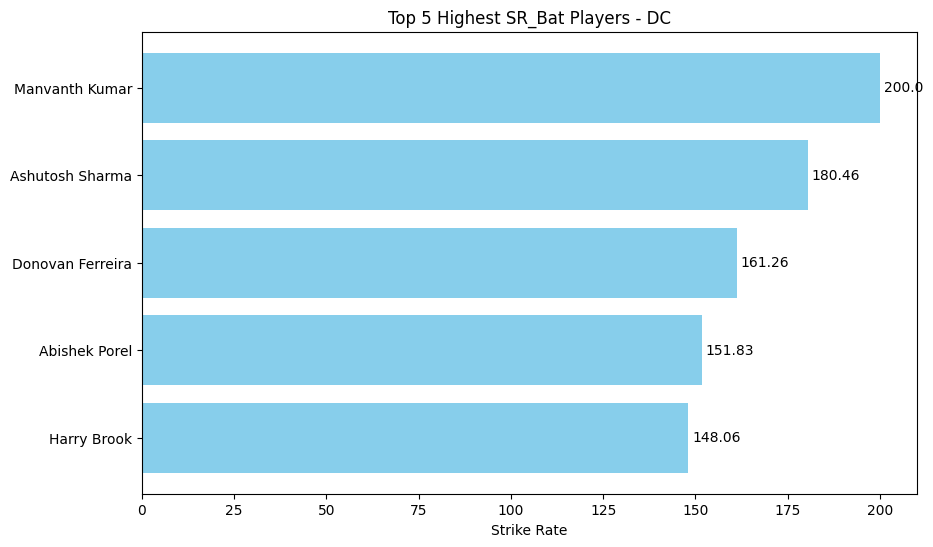

In [ ]:
import matplotlib.pyplot as plt

dc_t20_df_sorted = dc_t20_df.sort_values(by='SR_Bat', ascending=False)

# Get the top 5 players
top_5_players = dc_t20_df_sorted.head(5)

# Extract player names and SR_Bat values
players = top_5_players['Player']
sr_bat = top_5_players['SR_Bat']

# Create the horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(players, sr_bat, color='skyblue')
plt.xlabel("Strike Rate")
plt.title("Top 5 Highest SR_Bat Players - DC")
plt.gca().invert_yaxis()  # Invert y-axis to show highest SR at the top

# Add exact SR_Bat values next to each bar
for i, v in enumerate(sr_bat):
    plt.text(v + 1, i, str(v), color='black', va='center')

plt.show()

# **Kolkata Knight Riders**

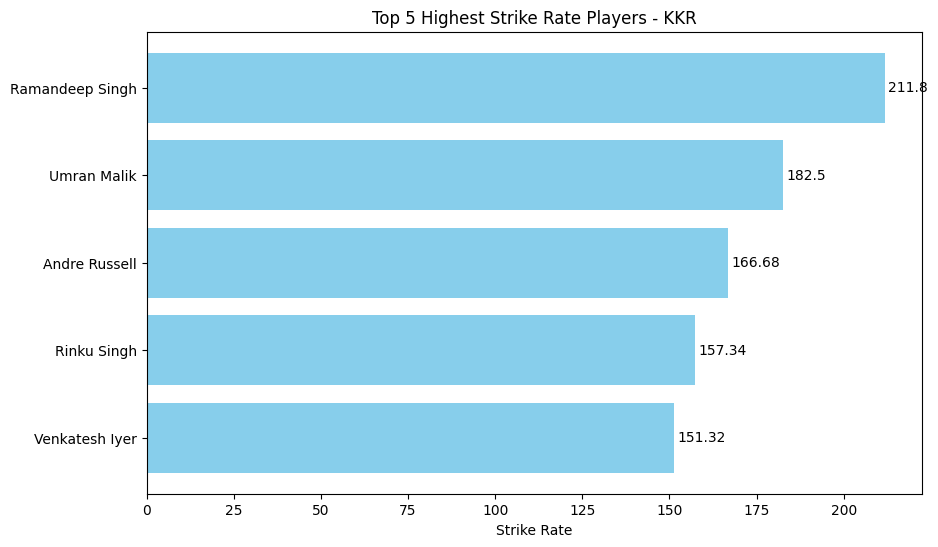

In [ ]:
# Sort the dataframe by SR_Bat in descending order
kkr_t20_df_sorted = kkr_t20_df.sort_values(by='SR_Bat', ascending=False)

# Get the top 5 players
top_5_players = kkr_t20_df_sorted.head(5)

# Extract player names and SR_Bat values
players = top_5_players['Player']
sr_bat = top_5_players['SR_Bat']

# Create the horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(players, sr_bat, color='skyblue')
plt.xlabel("Strike Rate")
plt.title("Top 5 Highest Strike Rate Players - KKR")
plt.gca().invert_yaxis()  # Invert y-axis to show highest SR at the top

# Add exact SR_Bat values next to each bar
for i, v in enumerate(sr_bat):
    plt.text(v + 1, i, str(v), color='black', va='center')

plt.show()

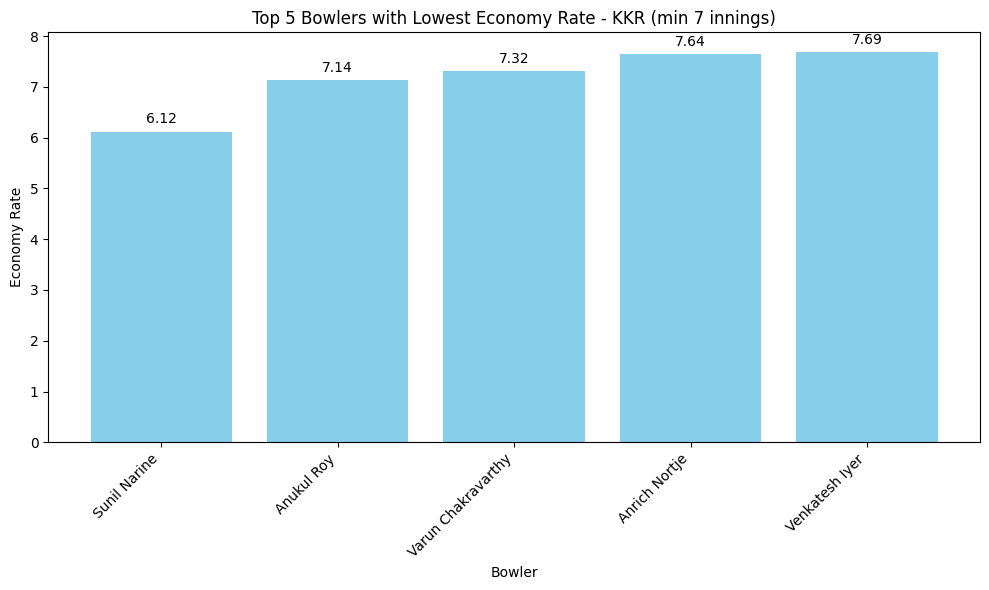

In [ ]:
# Filter for bowlers with minimum 7 innings bowled
kkr_bowlers = kkr_t20_df[kkr_t20_df['Innings_Bowl'] >= 20]

# Sort by economy rate in ascending order
kkr_bowlers_sorted = kkr_bowlers.sort_values(by='Econ')

# Get the top 5 bowlers
top_5_bowlers = kkr_bowlers_sorted.head(5)

# Extract player names and economy rates
players = top_5_bowlers['Player']
economy_rates = top_5_bowlers['Econ']

# Create the vertical bar plot
plt.figure(figsize=(10, 6))
plt.bar(players, economy_rates, color='skyblue')
plt.xlabel("Bowler")
plt.ylabel("Economy Rate")
plt.title("Top 5 Bowlers with Lowest Economy Rate - KKR (min 7 innings)")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping

# Add exact economy rate values above each bar
for i, v in enumerate(economy_rates):
    plt.text(i, v + 0.1, str(v), ha='center', va='bottom')

plt.show()

In [ ]:
kkr_t20_df

,Player,Matches,Innings_Bat,Runs,HS,Avg_Bat,SR_Bat,Hundreds,Fifties,Innings_Bowl,Overs,Wickets,BBI,Best_Wickets,SR_Bowl,Econ,Avg_Bowl,Four_Wicket_Hauls,Five_Wicket_Hauls,Formats_Included
0,Quinton de Kock,461,450.0,13113.0,140.0,31.83,138.48,8.0,83.0,0.0,0.0,0.0,-,0,0.00,0.00,0.00,0.0,0.0,T20s_Only
1,Sunil Narine,577,363.0,4473.0,109.0,15.16,130.57,1.0,17.0,565.0,2168.5,621.0,5/19,5,20.95,6.12,21.36,13.0,1.0,T20s_Only
2,Venkatesh Iyer,128,115.0,2925.0,104.0,36.11,151.32,1.0,16.0,66.0,156.3,48.0,6/20,6,19.54,7.69,25.04,0.0,1.0,T20s_Only
3,Rinku Singh,176,147.0,3377.0,79.0,36.31,157.34,0.0,20.0,8.0,14.0,7.0,2/3,2,12.00,9.07,18.14,0.0,0.0,T20s_Only
4,Andre Russell,610,526.0,9937.0,121.0,26.29,166.68,2.0,34.0,544.0,1558.2,524.0,5/15,5,17.84,8.77,26.08,9.0,1.0,T20s_Only
5,Ramandeep Singh,66,44.0,640.0,64.0,23.70,211.80,0.0,2.0,24.0,46.3,21.0,3/20,3,13.24,8.63,19.05,0.0,0.0,T20s_Only
6,Angkrish Raghuvanshi,21,18.0,385.0,54.0,24.06,134.14,0.0,1.0,0.0,0.0,0.0,-,0,0.00,0.00,0.00,0.0,0.0,T20s_Only
7,Harshit Rana,25,3.0,2.0,2.0,1.00,66.66,0.0,0.0,23.0,74.0,28.0,3/24,3,15.86,8.95,23.64,0.0,0.0,T20s_Only
8,Anrich Nortje,184,56.0,202.0,25.0,6.97,75.67,0.0,0.0,182.0,664.7,233.0,4/7,4,17.12,7.64,21.79,8.0,0.0,T20s_Only
9,Varun Chakravarthy,112,23.0,67.0,24.0,5.15,34.90,0.0,0.0,111.0,419.7,141.0,5/17,5,17.86,7.32,21.77,1.0,3.0,T20s_Only


# **Punjab Kings**

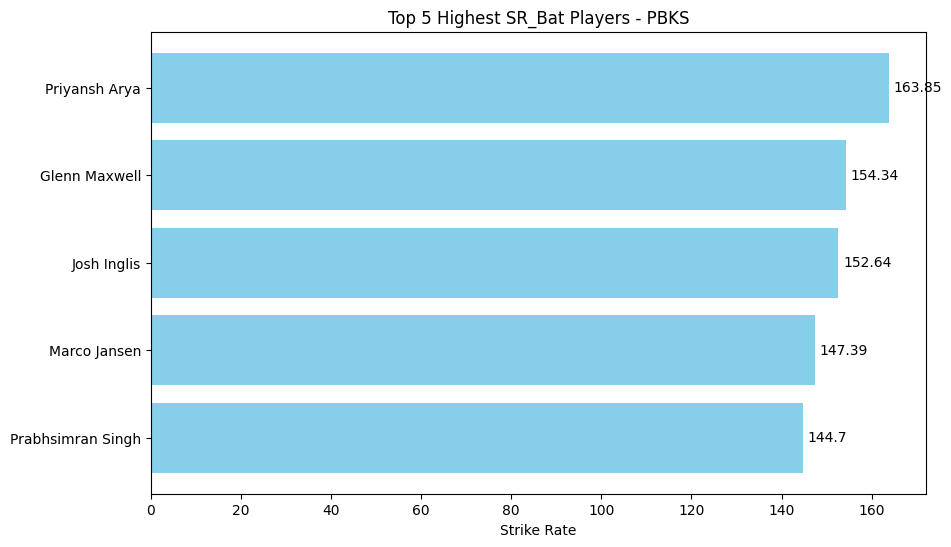

In [ ]:
# Sort the dataframe by SR_Bat in descending order
pbks_t20_df_sorted = pbks_t20_df.sort_values(by='SR_Bat', ascending=False)

# Get the top 5 players
top_5_players = pbks_t20_df_sorted.head(5)

# Extract player names and SR_Bat values
players = top_5_players['Player']
sr_bat = top_5_players['SR_Bat']

# Create the horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(players, sr_bat, color='skyblue')
plt.xlabel("Strike Rate")
plt.title("Top 5 Highest SR_Bat Players - PBKS")
plt.gca().invert_yaxis()  # Invert y-axis to show highest SR at the top

# Add exact SR_Bat values next to each bar
for i, v in enumerate(sr_bat):
    plt.text(v + 1, i, str(v), color='black', va='center')

plt.show()

In [ ]:
pbks_t20_df

,Player,Matches,Innings_Bat,Runs,HS,Avg_Bat,SR_Bat,Hundreds,Fifties,Innings_Bowl,Overs,Wickets,BBI,Best_Wickets,SR_Bowl,Econ,Avg_Bowl,Four_Wicket_Hauls,Five_Wicket_Hauls,Formats_Included
0,Marcus Stoinis,367,326.0,7307.0,147.0,30.45,143.38,2.0,37.0,227.0,556.8,197.0,4/23,4,16.96,8.99,25.40,6.0,0.0,T20s_Only
1,Prabhsimran Singh,87,86.0,2311.0,119.0,30.81,144.70,2.0,14.0,0.0,0.0,0.0,-,0,0.00,0.00,0.00,0.0,0.0,T20s_Only
2,Shreyas Iyer,269,259.0,6966.0,147.0,32.86,134.66,3.0,45.0,6.0,8.5,1.0,1/28,1,51.00,9.76,83.00,0.0,0.0,T20s_Only
3,Glenn Maxwell,566,528.0,12716.0,154.0,28.13,154.34,12.0,65.0,379.0,840.7,216.0,3/10,3,23.35,7.84,30.52,0.0,0.0,T20s_Only
4,Nehal Wadhera,36,31.0,656.0,64.0,25.23,137.81,0.0,4.0,2.0,2.8,1.0,1/0,1,17.00,4.59,13.00,0.0,0.0,T20s_Only
5,Shashank Singh,72,61.0,1134.0,68.0,24.13,143.90,0.0,7.0,26.0,60.0,17.0,3/4,3,21.18,8.30,29.29,0.0,0.0,T20s_Only
6,Marco Jansen,103,65.0,869.0,71.0,20.21,147.39,0.0,5.0,102.0,369.8,109.0,5/30,5,20.36,8.33,28.26,2.0,1.0,T20s_Only
7,Harpreet Brar,86,45.0,380.0,29.0,16.52,125.41,0.0,0.0,84.0,268.2,75.0,4/18,4,21.45,7.29,26.05,3.0,0.0,T20s_Only
8,Yuzvendra Chahal,390,50.0,87.0,10.0,4.58,49.90,0.0,0.0,386.0,1402.8,460.0,6/25,6,18.30,7.76,23.68,12.0,3.0,T20s_Only
9,Lockie Ferguson,205,65.0,288.0,30.0,8.73,97.83,0.0,0.0,204.0,719.8,258.0,5/21,5,16.74,7.61,21.22,10.0,2.0,T20s_Only


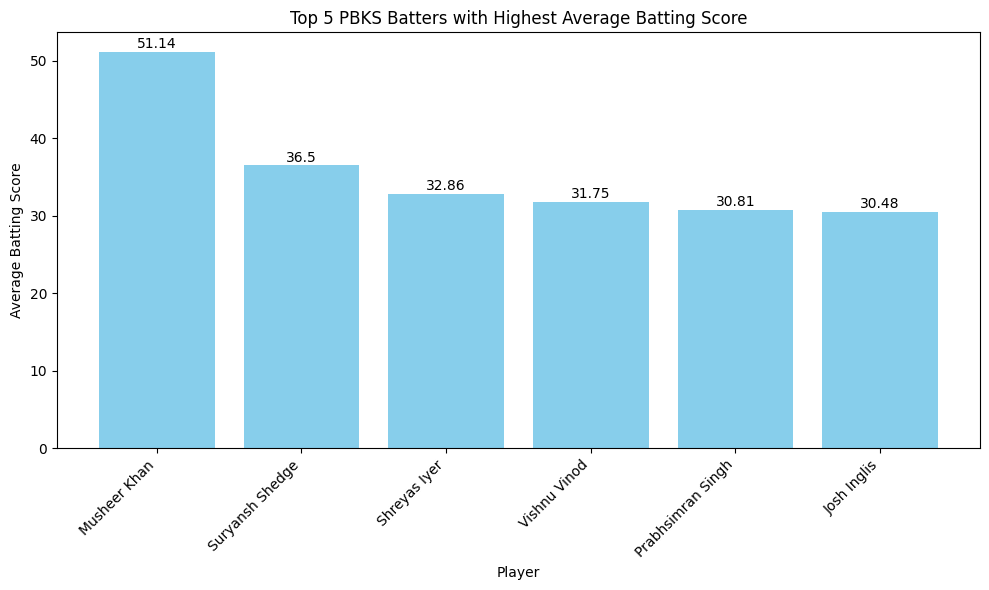

In [ ]:
# Sort the DataFrame by 'Avg_Bat' in descending order
pbks_t20_df_sorted = pbks_t20_df.sort_values(by='Avg_Bat', ascending=False)

# Get the top 5 batters
top_5_batters = pbks_t20_df_sorted.head(6)

# Extract player names and average batting scores
players = top_5_batters['Player']
avg_bat = top_5_batters['Avg_Bat']

# Create the bar graph
plt.figure(figsize=(10, 6))
plt.bar(players, avg_bat, color='skyblue')
plt.xlabel("Player")
plt.ylabel("Average Batting Score")
plt.title("Top 5 PBKS Batters with Highest Average Batting Score")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping

# Add exact average batting scores above each bar
for i, v in enumerate(avg_bat):
    plt.text(i, v + 0.1, str(v), ha='center', va='bottom')

plt.show()

In [ ]:

musheer_stats = pbks_t20_df[pbks_t20_df['Player'] == 'Musheer Khan']

if not musheer_stats.empty:
    print(musheer_stats)
else:
    print("Stats for Mohit Rathee not found in the DataFrame.")

          Player  Matches  Innings_Bat   Runs     HS  Avg_Bat  SR_Bat  \
19  Musheer Khan        9         15.0  716.0  203.0    51.14   47.89   

    Hundreds  Fifties  Innings_Bowl  Overs  Wickets   BBI  Best_Wickets  \
19       3.0      1.0          14.0   79.0      8.0  2/11             2   

    SR_Bowl  Econ  Avg_Bowl  Four_Wicket_Hauls  Five_Wicket_Hauls  \
19    59.25  2.72     26.88                0.0                0.0   

   Formats_Included  
19      All_Formats  


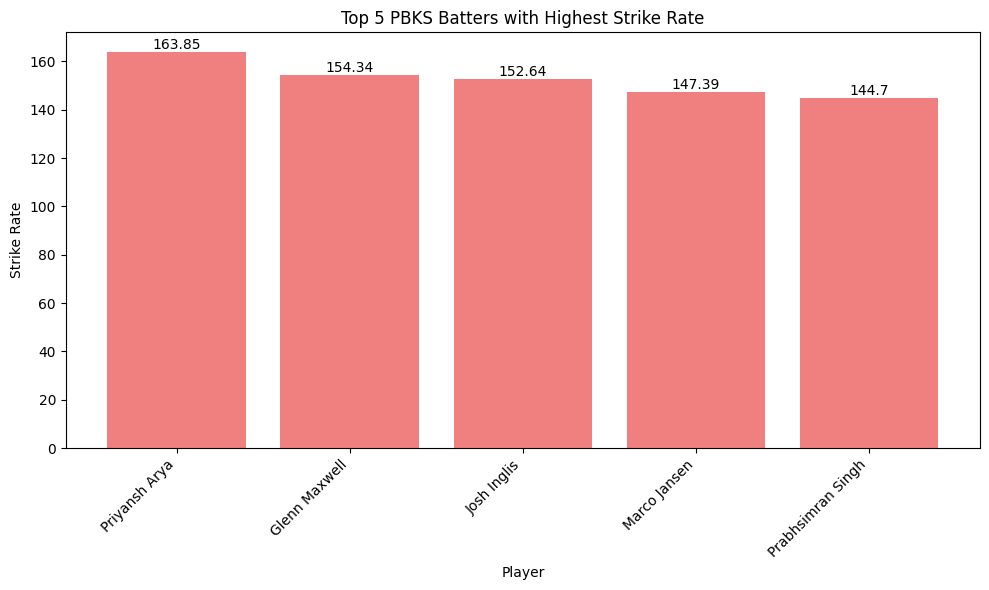

In [ ]:
# Sort the dataframe by SR_Bat in descending order
pbks_t20_df_sorted = pbks_t20_df.sort_values(by='SR_Bat', ascending=False)

# Get the top 5 players
top_5_players = pbks_t20_df_sorted.head(5)

# Extract player names and SR_Bat values
players = top_5_players['Player']
sr_bat = top_5_players['SR_Bat']

# Create the bar graph
plt.figure(figsize=(10, 6))
plt.bar(players, sr_bat, color='lightcoral')
plt.xlabel("Player")
plt.ylabel("Strike Rate")
plt.title("Top 5 PBKS Batters with Highest Strike Rate")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping

# Add exact SR_Bat values above each bar
for i, v in enumerate(sr_bat):
    plt.text(i, v + 0.1, str(v), ha='center', va='bottom')

plt.show()

In [ ]:
# Filter for bowlers with minimum economy rate of 4 and minimum 20 innings bowled
pbks_bowlers = pbks_t20_df[(pbks_t20_df['Econ'] >= 4) & (pbks_t20_df['Innings_Bowl'] >= 20)]

# Sort by economy rate in ascending order
pbks_bowlers_sorted = pbks_bowlers.sort_values(by='Econ')

# Display the bowlers
print(pbks_bowlers_sorted[['Player', 'Econ', 'Innings_Bowl']])

                Player  Econ  Innings_Bowl
23       Praveen Dubey  7.17          25.0
7        Harpreet Brar  7.29          84.0
9      Lockie Ferguson  7.61         204.0
8     Yuzvendra Chahal  7.76         386.0
3        Glenn Maxwell  7.84         379.0
21     Xavier Bartlett  7.99          61.0
17         Yash Thakur  8.08          60.0
5       Shashank Singh  8.30          26.0
6         Marco Jansen  8.33         102.0
13  Azmatullah Omarzai  8.34         145.0
12   VijayKumar Vyshak  8.49          35.0
18        Aaron Hardie  8.63          61.0
16         Kuldeep Sen  8.94          38.0
0       Marcus Stoinis  8.99         227.0


In [ ]:
# Filter for bowlers with minimum economy rate of 4 and minimum 20 innings bowled
pbks_bowlers = pbks_t20_df[(pbks_t20_df['Avg_Bowl'] >= 4) & (pbks_t20_df['Innings_Bowl'] >= 20)]

# Sort by economy rate in ascending order
pbks_bowlers_sorted = pbks_bowlers.sort_values(by='Avg_Bowl')

# Display the bowlers
print(pbks_bowlers_sorted[['Player', 'Avg_Bowl', 'Innings_Bowl']])

                Player  Avg_Bowl  Innings_Bowl
17         Yash Thakur     19.31          60.0
21     Xavier Bartlett     20.05          61.0
9      Lockie Ferguson     21.22         204.0
23       Praveen Dubey     21.67          25.0
12   VijayKumar Vyshak     22.74          35.0
8     Yuzvendra Chahal     23.68         386.0
0       Marcus Stoinis     25.40         227.0
7        Harpreet Brar     26.05          84.0
18        Aaron Hardie     26.69          61.0
13  Azmatullah Omarzai     28.19         145.0
6         Marco Jansen     28.26         102.0
5       Shashank Singh     29.29          26.0
3        Glenn Maxwell     30.52         379.0
16         Kuldeep Sen     34.50          38.0


In [ ]:
# Filter for bowlers with minimum economy rate of 4 and minimum 20 innings bowled
pbks_bowlers = pbks_t20_df[(pbks_t20_df['Econ'] >= 4) & (pbks_t20_df['Innings_Bowl'] >= 20)]

# Sort by economy rate (Econ) and then average bowling (Avg_Bowl) in ascending order
pbks_bowlers_sorted = pbks_bowlers.sort_values(by=['Econ', 'Avg_Bowl'])

# Display the sorted bowlers
print(pbks_bowlers_sorted[['Player', 'Econ', 'Avg_Bowl', 'Innings_Bowl']])

                Player  Econ  Avg_Bowl  Innings_Bowl
23       Praveen Dubey  7.17     21.67          25.0
7        Harpreet Brar  7.29     26.05          84.0
9      Lockie Ferguson  7.61     21.22         204.0
8     Yuzvendra Chahal  7.76     23.68         386.0
3        Glenn Maxwell  7.84     30.52         379.0
21     Xavier Bartlett  7.99     20.05          61.0
17         Yash Thakur  8.08     19.31          60.0
5       Shashank Singh  8.30     29.29          26.0
6         Marco Jansen  8.33     28.26         102.0
13  Azmatullah Omarzai  8.34     28.19         145.0
12   VijayKumar Vyshak  8.49     22.74          35.0
18        Aaron Hardie  8.63     26.69          61.0
16         Kuldeep Sen  8.94     34.50          38.0
0       Marcus Stoinis  8.99     25.40         227.0


In [ ]:
# Assuming 'pbks_t20_df' is your DataFrame
praveen_dubey_stats = pbks_t20_df[pbks_t20_df['Player'] == 'Praveen Dubey']

if not praveen_dubey_stats.empty:
    print(praveen_dubey_stats)
else:
    print("Stats for Praveen Dubey not found in the DataFrame.")

           Player  Matches  Innings_Bat   Runs    HS  Avg_Bat  SR_Bat  \
23  Praveen Dubey       25         18.0  146.0  33.0    13.27   99.31   

    Hundreds  Fifties  Innings_Bowl  Overs  Wickets   BBI  Best_Wickets  \
23       0.0      0.0          25.0   72.5     24.0  4/19             4   

    SR_Bowl  Econ  Avg_Bowl  Four_Wicket_Hauls  Five_Wicket_Hauls  \
23    18.12  7.17     21.67                1.0                0.0   

   Formats_Included  
23        T20s_Only  


# **Mumbai Indians**

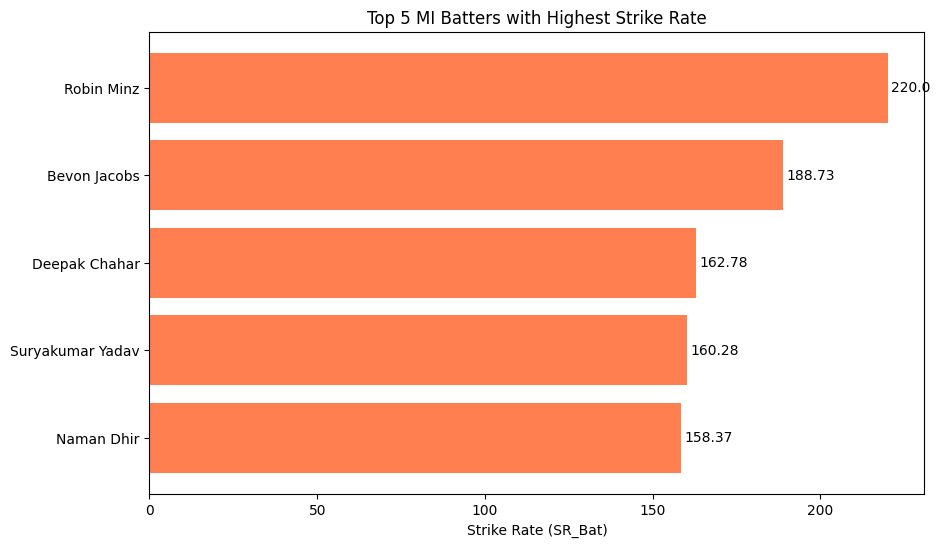

In [ ]:
# Sort the DataFrame by 'SR_Bat' in descending order
mi_t20_df_sorted = mi_t20_df.sort_values(by='SR_Bat', ascending=False)

# Get the top 5 players
top_5_mi_batters = mi_t20_df_sorted.head(5)

# Extract player names and SR_Bat values
players = top_5_mi_batters['Player']
sr_bat = top_5_mi_batters['SR_Bat']

# Create the bar graph with coral red color
plt.figure(figsize=(10, 6))
plt.barh(players, sr_bat, color='coral')  # Use coral color
plt.xlabel("Strike Rate (SR_Bat)")
plt.title("Top 5 MI Batters with Highest Strike Rate")
plt.gca().invert_yaxis() # Invert y-axis for better readability

# Add exact SR_Bat values next to each bar
for i, v in enumerate(sr_bat):
    plt.text(v + 1, i, str(v), color='black', va='center')

plt.show()

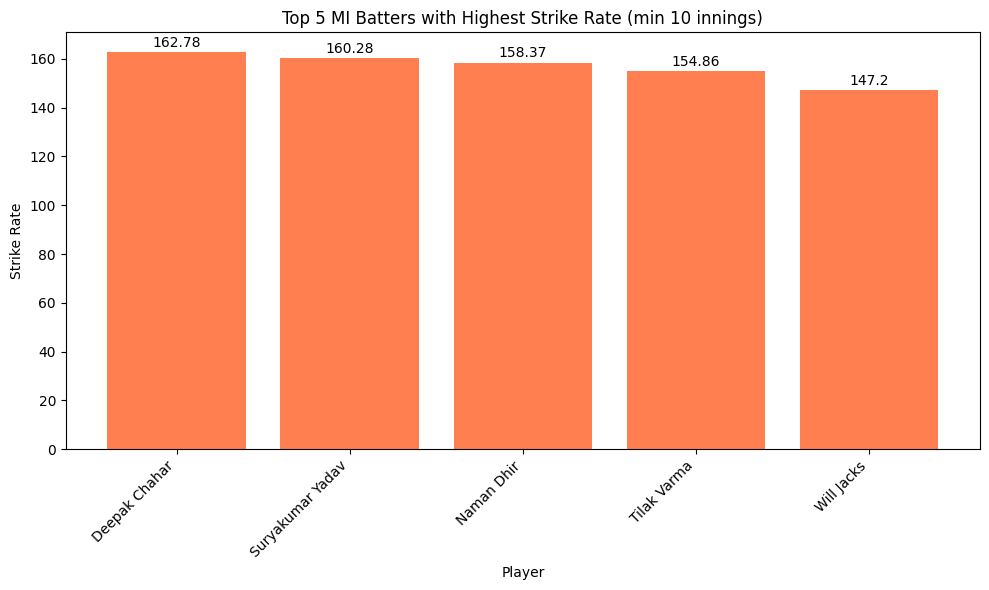

In [ ]:
# Filter for batters with minimum 10 innings
mi_batters = mi_t20_df[mi_t20_df['Innings_Bat'] >= 10]

# Sort by strike rate in descending order
mi_batters_sorted = mi_batters.sort_values(by='SR_Bat', ascending=False)

# Get the top 5 batters
top_5_batters = mi_batters_sorted.head(5)

# Extract player names and strike rates
players = top_5_batters['Player']
strike_rates = top_5_batters['SR_Bat']

# Create the bar graph
plt.figure(figsize=(10, 6))
plt.bar(players, strike_rates, color='coral')
plt.xlabel("Player")
plt.ylabel("Strike Rate")
plt.title("Top 5 MI Batters with Highest Strike Rate (min 10 innings)")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping

# Add exact strike rate values above each bar
for i, v in enumerate(strike_rates):
    plt.text(i, v + 1, str(v), ha='center', va='bottom')

plt.show()

In [ ]:
robin_minz_stats = mi_t20_df[mi_t20_df['Player'] == 'Robin Minz']

if not robin_minz_stats.empty:
    print(robin_minz_stats)
else:
    print("Stats for Robin Minz not found in the DataFrame.")

        Player  Matches  Innings_Bat  Runs    HS  Avg_Bat  SR_Bat  Hundreds  \
13  Robin Minz        5          4.0  44.0  36.0    14.67   220.0       0.0   

    Fifties  Innings_Bowl  Overs  Wickets BBI  Best_Wickets  SR_Bowl  Econ  \
13      0.0           0.0    0.0      0.0   -             0      0.0   0.0   

    Avg_Bowl  Four_Wicket_Hauls  Five_Wicket_Hauls Formats_Included  
13       0.0                0.0                0.0        T20s_Only  


In [ ]:
deepak_chahar_stats = mi_t20_df[mi_t20_df['Player'] == 'Deepak Chahar']

if not deepak_chahar_stats.empty:
    print(deepak_chahar_stats)
else:
    print("Stats for Deepak Chahar not found in the DataFrame.")

          Player  Matches  Innings_Bat   Runs    HS  Avg_Bat  SR_Bat  \
6  Deepak Chahar      175         60.0  455.0  55.0    14.68  162.78   

   Hundreds  Fifties  Innings_Bowl  Overs  Wickets  BBI  Best_Wickets  \
6       0.0      1.0         175.0  622.3    202.0  6/7             6   

   SR_Bowl  Econ  Avg_Bowl  Four_Wicket_Hauls  Five_Wicket_Hauls  \
6    18.49  7.85     24.18                3.0                3.0   

  Formats_Included  
6        T20s_Only  


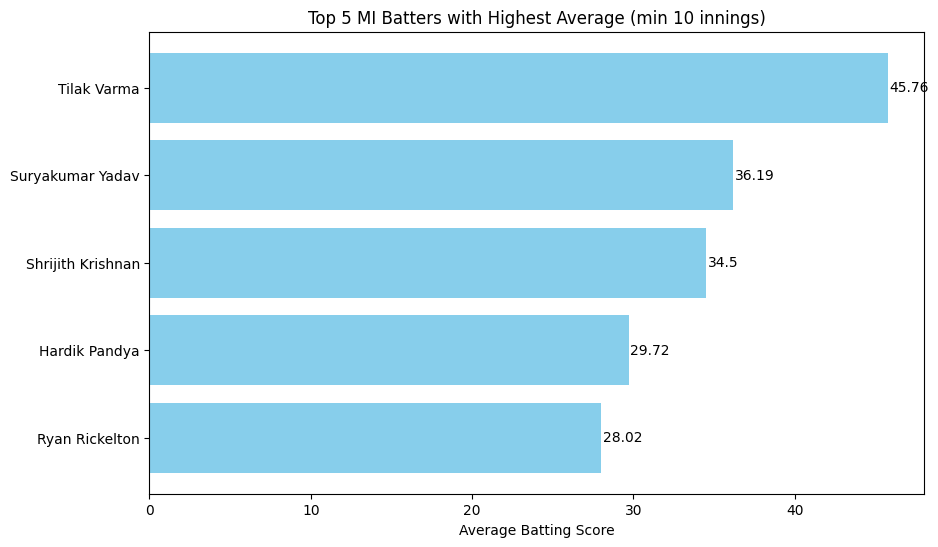

In [ ]:
# Filter for batters with at least 10 innings
mi_batters = mi_t20_df[mi_t20_df['Innings_Bat'] >= 10]

# Sort by average batting in descending order
mi_batters_sorted = mi_batters.sort_values(by='Avg_Bat', ascending=False)

# Get the top 5 batters
top_5_batters = mi_batters_sorted.head(5)

# Extract player names and average batting scores
players = top_5_batters['Player']
avg_bat = top_5_batters['Avg_Bat']

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.barh(players, avg_bat, color='skyblue')
plt.xlabel("Average Batting Score")
plt.title("Top 5 MI Batters with Highest Average (min 10 innings)")
plt.gca().invert_yaxis()  # Invert y-axis for better readability

# Add exact average batting scores next to each bar
for i, v in enumerate(avg_bat):
    plt.text(v + 0.1, i, str(v), color='black', va='center')

plt.show()

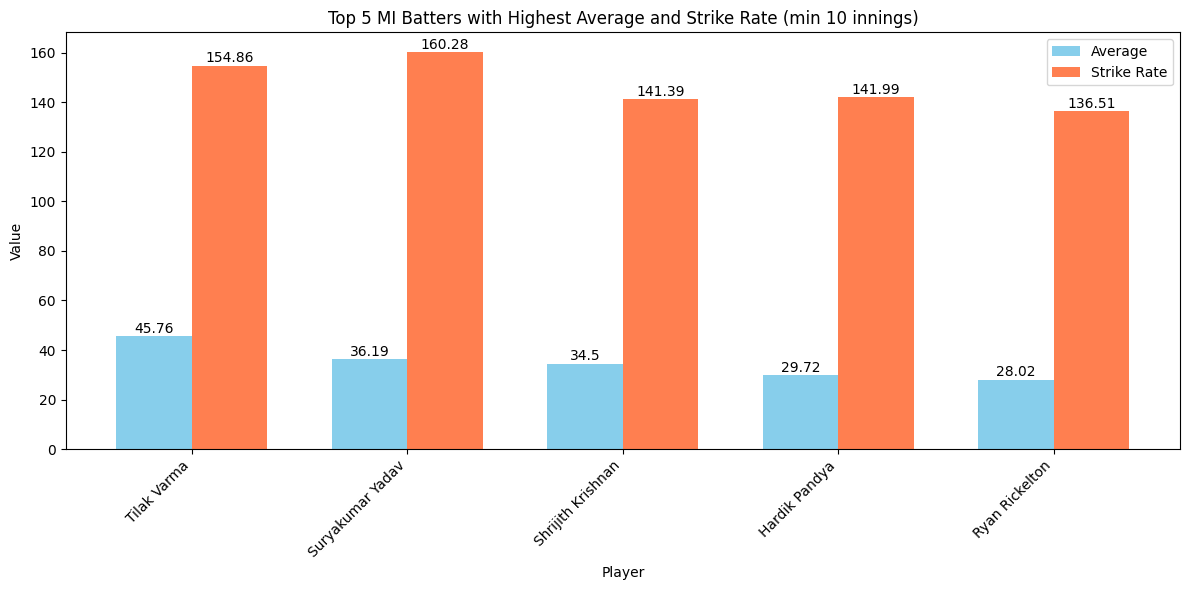

In [ ]:
# Filter for batters with minimum 10 innings
mi_batters = mi_t20_df[mi_t20_df['Innings_Bat'] >= 10]

# Sort by average and strike rate in descending order
mi_batters_sorted = mi_batters.sort_values(by=['Avg_Bat', 'SR_Bat'], ascending=False)

# Get the top 5 batters
top_batters = mi_batters_sorted.head(5)

# Extract player names, average, and strike rate
players = top_batters['Player']
avg_bat = top_batters['Avg_Bat']
sr_bat = top_batters['SR_Bat']

# Create the bar graph
plt.figure(figsize=(12, 6))
width = 0.35
x = np.arange(len(players))

plt.bar(x - width/2, avg_bat, width, label='Average', color='skyblue')
plt.bar(x + width/2, sr_bat, width, label='Strike Rate', color='coral')

plt.xlabel("Player")
plt.ylabel("Value")
plt.title("Top 5 MI Batters with Highest Average and Strike Rate (min 10 innings)")
plt.xticks(x, players, rotation=45, ha='right')
plt.legend()

# Add value labels
for i, v in enumerate(avg_bat):
    plt.text(i - width/2, v + 0.1, str(v), ha='center', va='bottom')
for i, v in enumerate(sr_bat):
    plt.text(i + width/2, v + 0.1, str(v), ha='center', va='bottom')


plt.tight_layout()
plt.show()

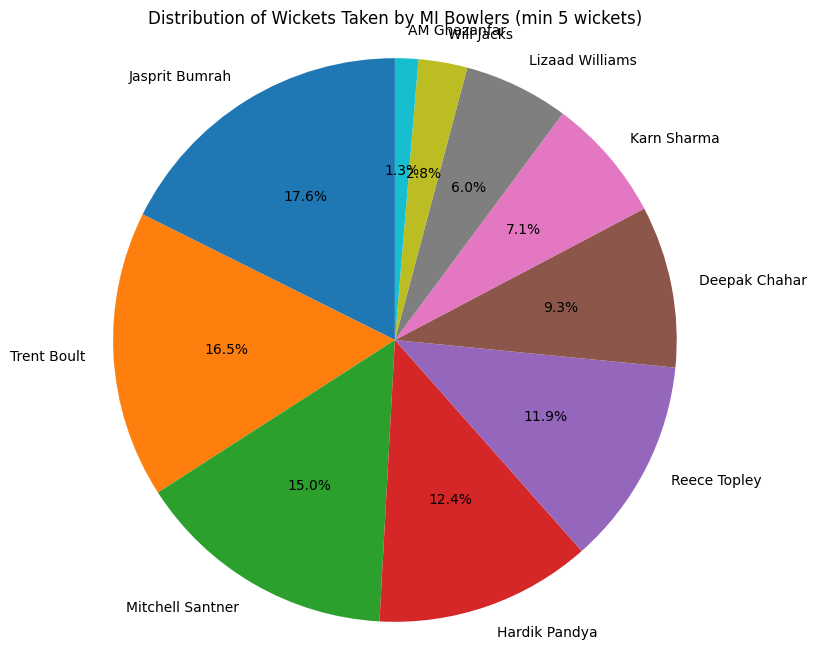

In [ ]:
# Filter for bowlers with at least 5 wickets
mi_bowlers = mi_t20_df[mi_t20_df['Wickets'] >= 5]

# Sort by wickets taken in descending order
mi_bowlers_sorted = mi_bowlers.sort_values(by='Wickets', ascending=False)

# Get the top bowlers
top_bowlers = mi_bowlers_sorted.head(10)  # Adjust the number as needed


# Extract player names and wickets taken
players = top_bowlers['Player']
wickets = top_bowlers['Wickets']

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(wickets, labels=players, autopct='%1.1f%%', startangle=90)
plt.title("Distribution of Wickets Taken by MI Bowlers (min 5 wickets)")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

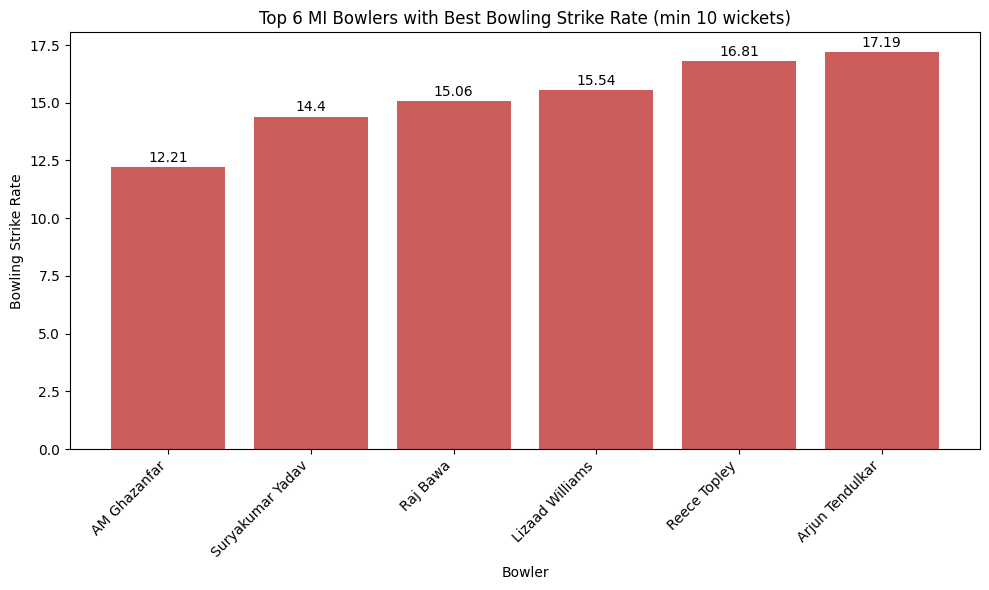

In [ ]:
# Filter for MI bowlers with minimum 10 wickets
mi_bowlers = mi_t20_df[mi_t20_df['Wickets'] >= 10]

# Sort by strike rate (SR_Bowl) in ascending order (best SR_Bowl is lowest)
mi_bowlers_sorted = mi_bowlers.sort_values(by='SR_Bowl')

# Get the top 6 bowlers
top_6_bowlers = mi_bowlers_sorted.head(6)

# Extract player names and strike rates
players = top_6_bowlers['Player']
sr_bowl = top_6_bowlers['SR_Bowl']

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(players, sr_bowl, color='indianred')
plt.xlabel("Bowler")
plt.ylabel("Bowling Strike Rate")
plt.title("Top 6 MI Bowlers with Best Bowling Strike Rate (min 10 wickets)")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping

# Add exact strike rate values above each bar
for i, v in enumerate(sr_bowl):
    plt.text(i, v + 0.1, str(v), ha='center', va='bottom')

plt.show()

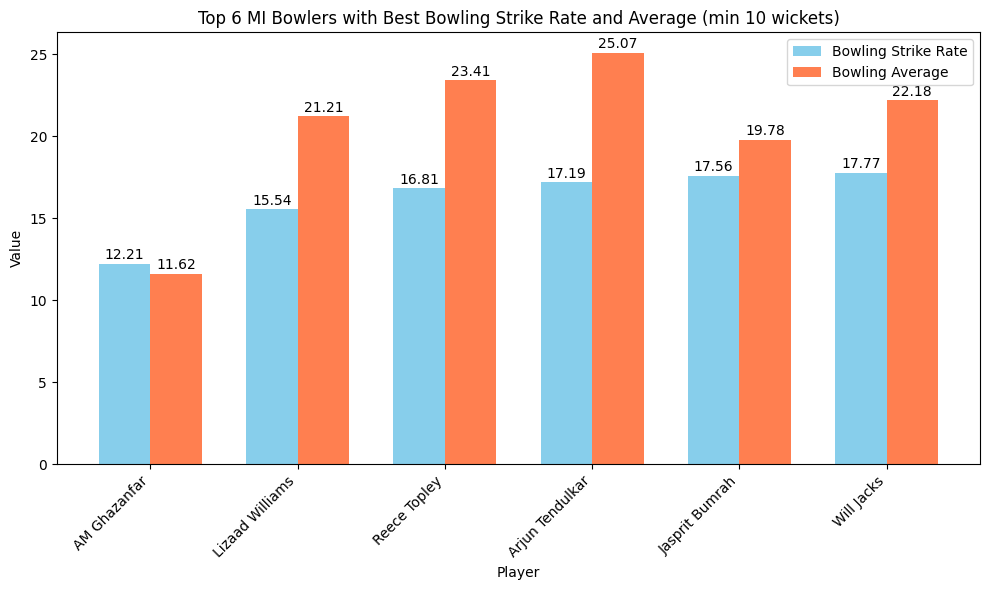

In [ ]:
# Filter for MI bowlers with at least 10 wickets
mi_bowlers = mi_t20_df[mi_t20_df['Wickets'] >= 25]

# Sort by strike rate (SR_Bowl) and average (Avg_Bowl) in ascending order
mi_bowlers_sorted = mi_bowlers.sort_values(by=['SR_Bowl', 'Avg_Bowl'])

# Get the top 5 bowlers
top_5_bowlers = mi_bowlers_sorted.head(6)

# Extract player names, strike rates, and averages
players = top_5_bowlers['Player']
sr_bowl = top_5_bowlers['SR_Bowl']
avg_bowl = top_5_bowlers['Avg_Bowl']

# Create the bar plot
plt.figure(figsize=(10, 6))
width = 0.35
x = np.arange(len(players))

plt.bar(x - width/2, sr_bowl, width, label='Bowling Strike Rate', color='skyblue')
plt.bar(x + width/2, avg_bowl, width, label='Bowling Average', color='coral')

plt.xlabel("Player")
plt.ylabel("Value")
plt.title("Top 6 MI Bowlers with Best Bowling Strike Rate and Average (min 10 wickets)")
plt.xticks(x, players, rotation=45, ha='right')
plt.legend()

# Add value labels
for i, v in enumerate(sr_bowl):
    plt.text(i - width/2, v + 0.1, str(v), ha='center', va='bottom')
for i, v in enumerate(avg_bowl):
    plt.text(i + width/2, v + 0.1, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

# **Sunrisers Hyderabad**

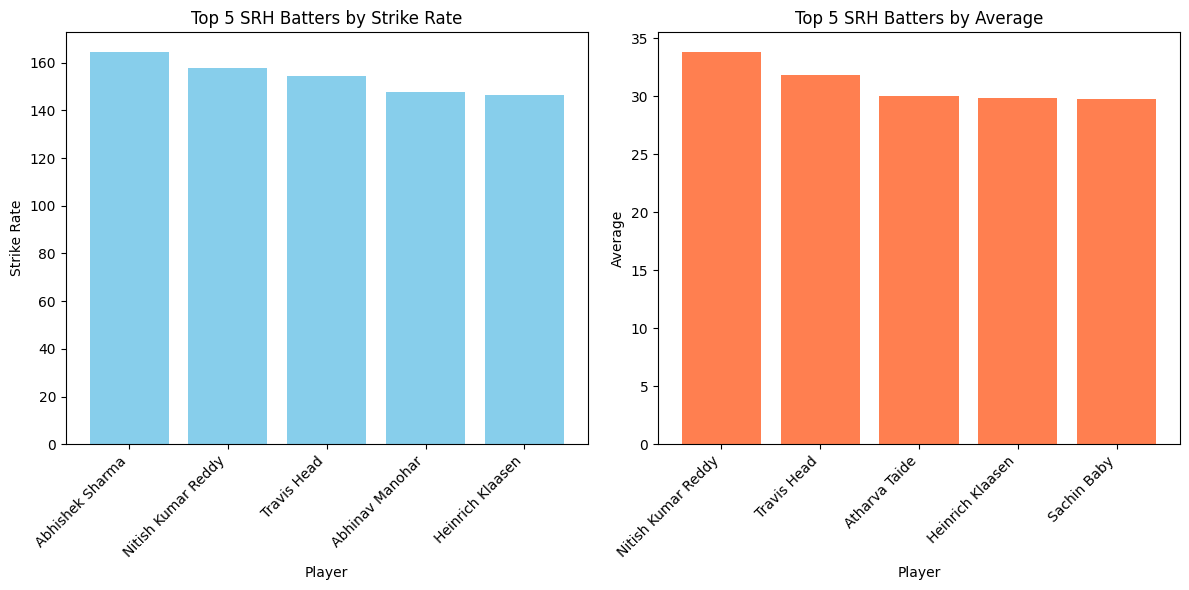

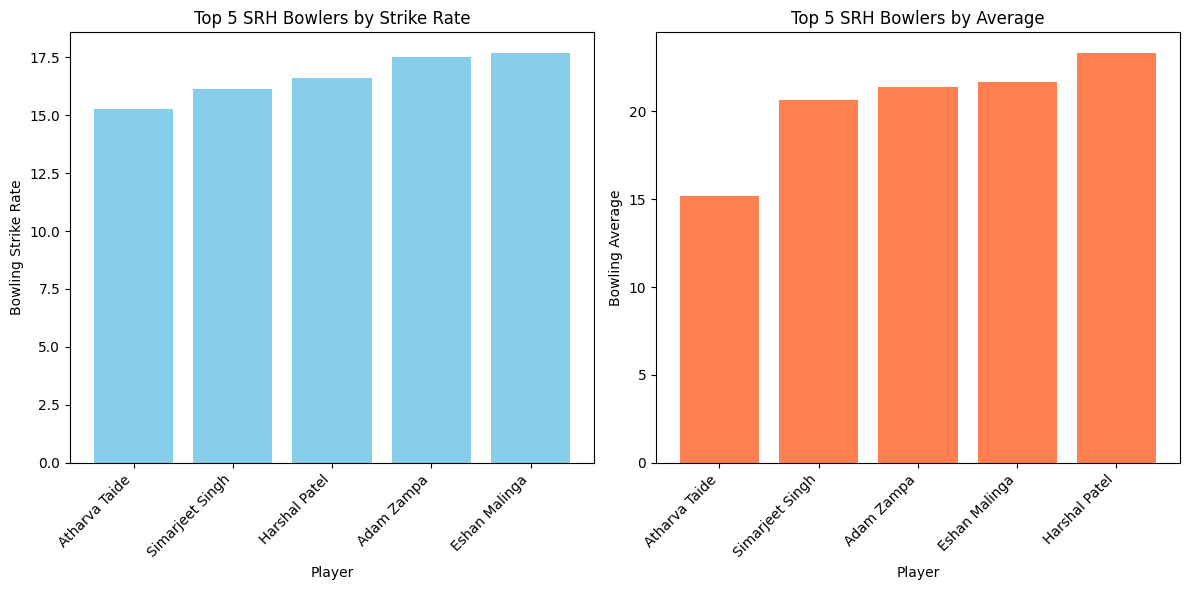

In [ ]:
def plot_srh_stats(srh_t20_df):
    """
    Generates graphs showing top 5 SRH batters and bowlers based on SR and Avg.

    Args:
        srh_t20_df: DataFrame containing SRH player stats.
    """

    min_innings = 10

    # Batting Stats
    srh_batters = srh_t20_df[srh_t20_df['Innings_Bat'] >= min_innings]
    srh_batters_sorted_sr = srh_batters.sort_values(by='SR_Bat', ascending=False).head(5)
    srh_batters_sorted_avg = srh_batters.sort_values(by='Avg_Bat', ascending=False).head(5)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.bar(srh_batters_sorted_sr['Player'], srh_batters_sorted_sr['SR_Bat'], color='skyblue')
    plt.xlabel("Player")
    plt.ylabel("Strike Rate")
    plt.title("Top 5 SRH Batters by Strike Rate")
    plt.xticks(rotation=45, ha='right')

    plt.subplot(1, 2, 2)
    plt.bar(srh_batters_sorted_avg['Player'], srh_batters_sorted_avg['Avg_Bat'], color='coral')
    plt.xlabel("Player")
    plt.ylabel("Average")
    plt.title("Top 5 SRH Batters by Average")
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

    #Bowling stats
    srh_bowlers = srh_t20_df[srh_t20_df['Innings_Bowl'] >= min_innings]
    srh_bowlers_sorted_sr = srh_bowlers.sort_values(by='SR_Bowl').head(5)
    srh_bowlers_sorted_avg = srh_bowlers.sort_values(by='Avg_Bowl').head(5)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.bar(srh_bowlers_sorted_sr['Player'], srh_bowlers_sorted_sr['SR_Bowl'], color='skyblue')
    plt.xlabel("Player")
    plt.ylabel("Bowling Strike Rate")
    plt.title("Top 5 SRH Bowlers by Strike Rate")
    plt.xticks(rotation=45, ha='right')

    plt.subplot(1, 2, 2)
    plt.bar(srh_bowlers_sorted_avg['Player'], srh_bowlers_sorted_avg['Avg_Bowl'], color='coral')
    plt.xlabel("Player")
    plt.ylabel("Bowling Average")
    plt.title("Top 5 SRH Bowlers by Average")
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

plot_srh_stats(srh_t20_df)

# **Rajasthan Royals**

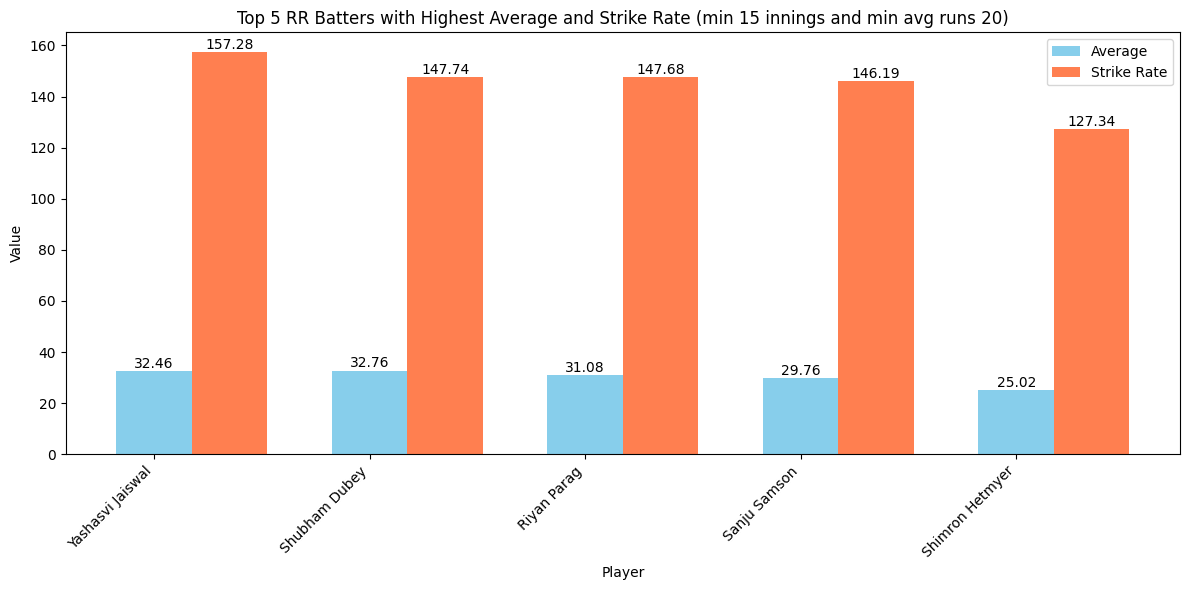

In [ ]:
# Filter for batters with minimum innings and minimum average runs
rr_batters = rr_t20_df[(rr_t20_df['Innings_Bat'] >= 15) & (rr_t20_df['Avg_Bat'] >= 20)]

# Sort by average and strike rate in descending order
rr_batters_sorted = rr_batters.sort_values(by=['SR_Bat', 'Avg_Bat'], ascending=False)

# Get the top 5 batters
top_batters = rr_batters_sorted.head(5)

# Extract player names, average, and strike rate
players = top_batters['Player']
avg_bat = top_batters['Avg_Bat']
sr_bat = top_batters['SR_Bat']

# Create the bar graph
plt.figure(figsize=(12, 6))
width = 0.35
x = range(len(players))

plt.bar(x, avg_bat, width, label='Average', color='skyblue')
plt.bar([i + width for i in x], sr_bat, width, label='Strike Rate', color='coral')

plt.xlabel("Player")
plt.ylabel("Value")
plt.title("Top 5 RR Batters with Highest Average and Strike Rate (min 15 innings and min avg runs 20)")
plt.xticks(x, players, rotation=45, ha='right')
plt.legend()

# Add value labels
for i, v in enumerate(avg_bat):
    plt.text(i, v + 0.1, str(v), ha='center', va='bottom')
for i, v in enumerate(sr_bat):
    plt.text(i + width, v + 0.1, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()
